##### PART - I #####

In [4]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import spacy
import collections
import numpy as np
from spacy.en import English
import string
import unicodedata
import gensim
import re
from collections import Counter
from itertools import chain
from scipy.spatial import distance
import spacy

nlp = spacy.load('en')
parser = English()
sqd_data = pd.read_json("/data/data_repo/train-v1.1.json")

In [5]:
sqd_data.head()

,data,version
0,"{'paragraphs': [{'context': 'Architecturally, ...",1.1
1,{'paragraphs': [{'context': 'Beyoncé Giselle K...,1.1
2,{'paragraphs': [{'context': 'Montana i/mɒnˈtæn...,1.1
3,"{'paragraphs': [{'context': 'The phrase ""in wh...",1.1
4,{'paragraphs': [{'context': 'The emergence of ...,1.1


In [7]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/home/aleena/Downloads/GoogleNews-vectors-negative300.3.bin', binary=True)


##### Prepare Stopwords list, question type mapping list, punctuation mark list #####

In [19]:
stopword = stopwords.words('english')
qtntype_list = ['How', 'What', 'When', 'Why', 'Which', 'Who','Whom', 'Where']
pun_list = list(string.punctuation)
delelements_list = stopword + qtntype_list + pun_list


In [20]:
qtntype_list

['How', 'What', 'When', 'Why', 'Which', 'Who', 'Whom', 'Where']

In [21]:
row_list = ['How many','How much','What','When','Where','Who', 'Which','Whom','PERSON',
          'NORP', 'FAC','LOC','PRODUCT', 'EVENT','WORK_OF_ART','LANGUAGE' ,'DATE' ,
          'TIME' ,'PERCENT' ,'MONEY' ,'ORDINAL','CARDINAL','GPE', 'ORG']


column_list = ['PERSON','NORP', 'FAC','LOC','PRODUCT', 'EVENT','WORK_OF_ART','LANGUAGE' ,'DATE' ,
               'TIME' ,'PERCENT' ,'MONEY' ,'ORDINAL','CARDINAL','GPE','ORG']

In [22]:
co_occ_matrix = np.zeros((len(row_list), len(column_list)), dtype = int)
co_occ_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
len(sqd_data)

442

## Real execution for 442 paragraphs

In [8]:
def replace_all(repls, str):
   # return re.sub('|'.join(repls.keys()), lambda k: repls[k.group(0)], str)                                    
   return re.sub('|'.join(re.escape(key) for key in repls.keys()),
                 lambda k: repls[k.group(0)], str)

In [9]:
def preprocess_question(para_question):
    question_list = []
    for i in range(len(para_question)):
        l1 = para_question[i]['question']
        l1 = unicodedata.normalize('NFKD', l1).encode('ascii','ignore').decode('utf-8')
        question_list.append(l1)
    
    #Appropriate question type replacement
    Question_list = []
    for i in range(len(question_list)):
        Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which", "where": "Where", "who":"Who" }, question_list[i]))
        
    return Question_list   

In [10]:
def preprocess_text(para_context):

    context = unicodedata.normalize('NFKD', para_context).encode('ascii','ignore').decode('utf-8')
    #print(context)
    #sentence_tokeniztion
    senttokenized_context = sent_tokenize(context)
    sentencelist = []
    for sent_token in senttokenized_context:
        sentencelist.append(sent_token) 
    
    sentence_list = []
    lemmatizer = WordNetLemmatizer()


    for i in sentencelist:
        words = nltk.word_tokenize(i)
        words = ([x.lower() for x in words])
        words = ([x for x in words if x not in delelements_list])
        words = [lemmatizer.lemmatize(x) for x in words]
        words = [[s.encode('ascii').decode('utf-8') for s in words]]
        sentence_list.append(words)
    return sentencelist, sentence_list

In [11]:
def question_type_extractor(question_mapping):
    Question_mapping = []
    for i in range(len(question_mapping)):
        if question_mapping[i] != 'How many' and question_mapping[i] != 'How much':
            Question_mapping.append(question_mapping[i].split()[0])
        else:
             Question_mapping.append(question_mapping[i])
    return Question_mapping

In [12]:
def wmd_que_ans_pair(que_list, sen_list):
    wmd_matrix = np.zeros([len(que_list),len(sen_list)]) 
    for i in range(len(que_list)):
        for j in range(len(sen_list)):
            wmd_matrix[i,j] =  word2vec_model.wmdistance(que_list[i],sen_list[j])  
    wmd_df = pd.DataFrame(wmd_matrix)
    wmd_df['sentence'] = wmd_df.T.idxmin()
    wmd_df['qnno'] = wmd_df.index
    que_no_ans_sen_no = []
    for i in range(len(wmd_df)):
        que_no_ans_sen_no.append([wmd_df['qnno'][i], wmd_df['sentence'][i]])
    qn_sentence = []
    for i in range(len(que_no_ans_sen_no)):
        if que_no_ans_sen_no[i][0] == que_list.index(que_list[i]):
            qn_sentence.append(que_list[i])
    an_sentence = []
    for i in range(len(que_no_ans_sen_no)):
        for j in range(len(sen_list)):
            if que_no_ans_sen_no[i][1] == sen_list.index(sen_list[j]):
                an_sentence.append(sen_list[j]) 
    return qn_sentence, an_sentence

In [13]:
def que_ner_ans_ner(que_sentence, ans_sentence):
    ans_sentence_mapping = []
    for i in range(len(ans_sentence)):
        doc_ans = nlp(ans_sentence[i])
        for ent in doc_ans.ents:
            ans_sentence_mapping.append([i,ent.label_])

    que_sentence_mapping = []
    for i in range(len(que_sentence)):
        doc_que = nlp(que_sentence[i])
        for ent in doc_que.ents:
            que_sentence_mapping.append([i,ent.label_])
    return que_sentence_mapping, ans_sentence_mapping

In [14]:
def que_df_ans_df(que_sen_map, ans_sen_map):
    qno_anstag_df = pd.DataFrame(ans_sen_map,columns = ['QuestionNo','AnswerTag'])
    qno_quetag_df = pd.DataFrame(que_sen_map, columns = ['QuestionNo', 'QuestionTag'])
    return qno_quetag_df, qno_anstag_df 

In [15]:
def que_ans_combo_(questionword, answerword):
    ques_ans_combo = []
    for i in range(len(questionword)):
        for j in range(len(answerword)):
            ques_ans_combo.append([questionword[i],answerword[j]])
    return(ques_ans_combo)

In [16]:
def question_type(process_que_list):
    question_mapping = [] 
    for i in range(len(process_que_list)):
        l2 = nltk.word_tokenize(process_que_list[i])
        #print(len(l2))
        #print(l2)
        missed = l2[-1]        
        if missed == '?':
            for j in range(len(l2)):


                if l2[j] in qtntype_list:
                    combine_list = l2[j]+" "+l2[j+1]
                    question_mapping.append(combine_list)

        else:

             for k in range(len(l2)):#8

                if k < len(l2)-1:  #7        

                    if l2[k] in qtntype_list:
                        combine_list = l2[k]+" "+l2[k+1]
                        question_mapping.append(combine_list) 
                else:

                        if l2[k] in qtntype_list:
                            combine_list = l2[k]+" "+'abc'
                            question_mapping.append(combine_list) 
    return question_mapping

In [24]:
for i in range(len(sqd_data)):
    print(i)
    paragraph_pointer = sqd_data.data[i]['paragraphs'] 

    #print(i, " ", len(paragraph_pointer))
    for j in range(len(paragraph_pointer)):#no of paragraphs in a row of the df
        processed_sen_list, process_sen_tokenized_list = preprocess_text(paragraph_pointer[j]['context']) 
        processed_que_list = preprocess_question(paragraph_pointer[j]['qas'])
        question_mapping = question_type(processed_que_list)
        que_type_extract = question_type_extractor(question_mapping)
        #print(que_type_extract)
        que_sen, ans_sen = wmd_que_ans_pair(processed_que_list, processed_sen_list)
        #print(wmd_dat)
#         print(que_sen)
#         print()
#         print(ans_sen)
        que_sen_map, ans_sen_map = que_ner_ans_ner(que_sen, ans_sen)
        que_no_quetag_df, que_no_anstag_df = que_df_ans_df(que_sen_map, ans_sen_map)
        
        for i in range(len(que_type_extract)):

            question_words = que_no_quetag_df[que_no_quetag_df['QuestionNo']== i]['QuestionTag'].tolist() + [que_type_extract[i]]
            ans_words = que_no_anstag_df[que_no_anstag_df['QuestionNo']==i]['AnswerTag'].tolist()
            combo = que_ans_combo_(question_words, ans_words)
            
            for i, v1 in enumerate(row_list):
                for j, v2 in enumerate(column_list):
                    for k in combo:
                        if [v1, v2] == k:
                            co_occ_matrix[i, j]+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [85]:
##trial and error
for i in range(len(sqd_data)):
   
    paragraph_pointer = sqd_data.data[i]['paragraphs'] 

    #print(i, " ", len(paragraph_pointer))
    for j in range(len(paragraph_pointer)):#no of paragraphs in a row of the df
        processed_sen_list, process_sen_tokenized_list = preprocess_text(paragraph_pointer[j]['context']) 
        processed_que_list = preprocess_question(paragraph_pointer[j]['qas'])
        question_mapping = question_type(processed_que_list)
        que_type_extract = question_type_extractor(question_mapping)
        #print(que_type_extract)
        que_sen, ans_sen = wmd_que_ans_pair(processed_que_list, processed_sen_list)
        #print(wmd_dat)
#         print(que_sen)
#         print()
#         print(ans_sen)
        que_sen_map, ans_sen_map = que_ner_ans_ner(que_sen, ans_sen)
        que_no_quetag_df, que_no_anstag_df = que_df_ans_df(que_sen_map, ans_sen_map)
        
        for i in range(len(que_type_extract)):

            question_words = que_no_quetag_df[que_no_quetag_df['QuestionNo']== i]['QuestionTag'].tolist() + [que_type_extract[i]]
            ans_words = que_no_anstag_df[que_no_anstag_df['QuestionNo']==i]['AnswerTag'].tolist()
            combo = que_ans_combo_(question_words, ans_words)
print(len(combo))

12


In [25]:
co_occ_matrix_df = pd.DataFrame(co_occ_matrix, index = row_list, columns= column_list)
co_occ_matrix_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,1595,1496,165,422,30,155,174,52,2719,112,330,233,488,5361,3512,3522
How much,319,269,20,84,14,26,18,18,729,24,336,352,81,528,650,684
What,20672,15822,1462,4499,458,1298,2082,822,19312,643,2131,854,3984,12788,29030,32959
When,3168,2244,182,580,60,253,295,97,4704,98,53,91,790,1670,4273,4512
Where,2018,1263,304,577,36,111,152,46,1428,33,38,36,397,968,3536,3078
Who,8370,3539,225,703,92,292,530,101,4188,93,94,105,999,1975,5472,7098
Which,3886,2278,339,821,88,208,354,107,2771,80,149,127,684,1737,4890,5017
Whom,297,131,10,24,1,13,14,5,150,0,4,4,40,61,216,261
PERSON,19801,4338,498,1145,156,399,1082,238,7442,212,200,238,1420,3803,8492,9829
NORP,4714,12553,217,1346,115,343,424,405,4348,93,709,134,855,2854,8436,6013


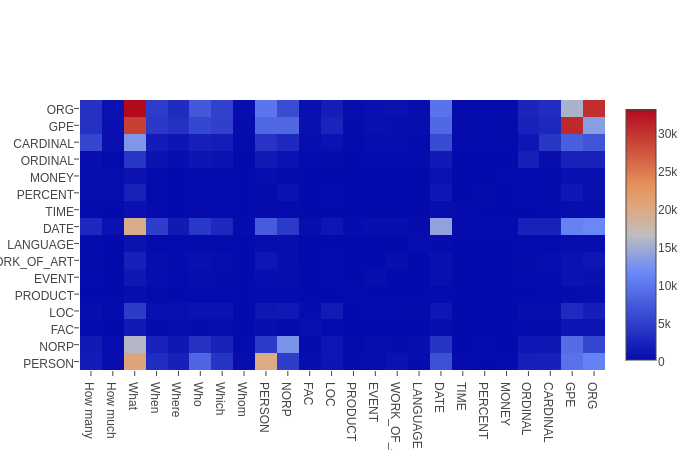

In [134]:
from IPython.display import Image
Image(filename='newplot (3).png')

In [138]:
![image](data/newplot.png?raw=true)

/bin/sh: 1: Syntax error: word unexpected (expecting ")")


In [26]:
co_occ_matrix_df['Tags'] = co_occ_matrix_df.index

In [122]:
#heatmap
melt_co_occ_matrix_df = pd.melt(co_occ_matrix_df,id_vars = ['Tags'])
melt_co_occ_matrix_df.head()

import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=melt_co_occ_matrix_df['value'],
                  x=melt_co_occ_matrix_df['Tags'] ,
                  y=melt_co_occ_matrix_df['variable'])
data=[trace]
py.iplot(data)

## Normalizing to bring out the pattern

In [28]:
from sklearn.preprocessing import normalize

In [25]:
a = [ 0.07770701,  0.07388535,  0.00803528,  0.02052915,  0.00146987,
         0.00744733,  0.00837825,  0.00254777,  0.13395394,  0.0055855 ,
         0.01646252,  0.01136698,  0.02395884,  0.26359628,  0.17246448,
         0.17261146]
b = []
for i in a:
    b.append(1-i)
print(b)
print(np.sum(b))
print(np.sum(a))

[0.92229299, 0.92611465, 0.99196472, 0.97947085, 0.99853013, 0.99255267, 0.99162175, 0.99745223, 0.86604606, 0.9944145, 0.98353748, 0.98863302, 0.97604116, 0.73640372, 0.82753552, 0.8273885400000001]
14.99999999
1.00000001


In [29]:
normed_matrix = normalize(co_occ_matrix, axis=1, norm='l1')    #### dividing by sum of row...
normed_matrix

/data/Environment/finite_env/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning:

Data with input dtype int64 was converted to float64 by the normalize function.



array([[ 0.0783168 ,  0.07345576,  0.00810174,  0.02072081,  0.00147304,
         0.00761072,  0.00854365,  0.00255328,  0.13350683,  0.00549936,
         0.01620348,  0.01144064,  0.0239615 ,  0.26323284,  0.17244427,
         0.17293528],
       [ 0.07683044,  0.06478805,  0.00481696,  0.02023121,  0.00337187,
         0.00626204,  0.00433526,  0.00433526,  0.17557803,  0.00578035,
         0.08092486,  0.08477842,  0.01950867,  0.12716763,  0.15655106,
         0.16473988],
       [ 0.13890979,  0.10631921,  0.00982421,  0.03023196,  0.00307763,
         0.00872218,  0.01399043,  0.0055236 ,  0.12977099,  0.00432077,
         0.0143197 ,  0.00573863,  0.02677131,  0.08593162,  0.19507311,
         0.22147484],
       [ 0.1373212 ,  0.09726918,  0.00788903,  0.02514088,  0.00260078,
         0.01096662,  0.01278717,  0.00420459,  0.20390117,  0.00424794,
         0.00229736,  0.00394452,  0.03424361,  0.07238838,  0.1852189 ,
         0.19557867],
       [ 0.14392697,  0.09007917,  0

In [433]:
np.sum(normed_matrix, axis = 0)

array([ 3.35029408,  2.23785372,  0.36669167,  0.69971754,  0.1082888 ,
        0.27867102,  0.43637048,  0.22614847,  3.29421606,  0.2715667 ,
        0.59455212,  0.41153424,  0.72788247,  2.33921736,  4.13958661,
        4.51740865])

In [30]:
normed_matrix_df = pd.DataFrame(normed_matrix, index = row_list, columns= column_list)
normed_matrix_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,0.078317,0.073456,0.008102,0.020721,0.001473,0.007611,0.008544,0.002553,0.133507,0.005499,0.016203,0.011441,0.023962,0.263233,0.172444,0.172935
How much,0.076830,0.064788,0.004817,0.020231,0.003372,0.006262,0.004335,0.004335,0.175578,0.005780,0.080925,0.084778,0.019509,0.127168,0.156551,0.164740
What,0.138910,0.106319,0.009824,0.030232,0.003078,0.008722,0.013990,0.005524,0.129771,0.004321,0.014320,0.005739,0.026771,0.085932,0.195073,0.221475
When,0.137321,0.097269,0.007889,0.025141,0.002601,0.010967,0.012787,0.004205,0.203901,0.004248,0.002297,0.003945,0.034244,0.072388,0.185219,0.195579
Where,0.143927,0.090079,0.021682,0.041153,0.002568,0.007917,0.010841,0.003281,0.101847,0.002354,0.002710,0.002568,0.028315,0.069039,0.252193,0.219528
Who,0.247078,0.104469,0.006642,0.020752,0.002716,0.008620,0.015645,0.002981,0.123627,0.002745,0.002775,0.003100,0.029490,0.058301,0.161530,0.209529
Which,0.165109,0.096788,0.014403,0.034883,0.003739,0.008838,0.015041,0.004546,0.117735,0.003399,0.006331,0.005396,0.029062,0.073802,0.207767,0.213163
Whom,0.241267,0.106418,0.008123,0.019496,0.000812,0.010561,0.011373,0.004062,0.121852,0.000000,0.003249,0.003249,0.032494,0.049553,0.175467,0.212023
PERSON,0.333952,0.073162,0.008399,0.019311,0.002631,0.006729,0.018248,0.004014,0.125512,0.003575,0.003373,0.004014,0.023949,0.064139,0.143221,0.165770
NORP,0.108221,0.288184,0.004982,0.030901,0.002640,0.007874,0.009734,0.009298,0.099819,0.002135,0.016277,0.003076,0.019629,0.065520,0.193668,0.138043


In [31]:
new_normed_matrix  = 1 - normed_matrix

In [32]:
new_normed_matrix

array([[ 0.9216832 ,  0.92654424,  0.99189826,  0.97927919,  0.99852696,
         0.99238928,  0.99145635,  0.99744672,  0.86649317,  0.99450064,
         0.98379652,  0.98855936,  0.9760385 ,  0.73676716,  0.82755573,
         0.82706472],
       [ 0.92316956,  0.93521195,  0.99518304,  0.97976879,  0.99662813,
         0.99373796,  0.99566474,  0.99566474,  0.82442197,  0.99421965,
         0.91907514,  0.91522158,  0.98049133,  0.87283237,  0.84344894,
         0.83526012],
       [ 0.86109021,  0.89368079,  0.99017579,  0.96976804,  0.99692237,
         0.99127782,  0.98600957,  0.9944764 ,  0.87022901,  0.99567923,
         0.9856803 ,  0.99426137,  0.97322869,  0.91406838,  0.80492689,
         0.77852516],
       [ 0.8626788 ,  0.90273082,  0.99211097,  0.97485912,  0.99739922,
         0.98903338,  0.98721283,  0.99579541,  0.79609883,  0.99575206,
         0.99770264,  0.99605548,  0.96575639,  0.92761162,  0.8147811 ,
         0.80442133],
       [ 0.85607303,  0.90992083,  0

In [33]:
new_normed_matrix_df = pd.DataFrame(new_normed_matrix, index = row_list, columns= column_list)

In [34]:
new_normed_matrix_df['Tags'] = new_normed_matrix_df.index

In [35]:
melt_new_normed_matrix_df = pd.melt(new_normed_matrix_df,id_vars = ['Tags'])
melt_new_normed_matrix_df.head()

,Tags,variable,value
0,How many,PERSON,0.921683
1,How much,PERSON,0.923170
2,What,PERSON,0.861090
3,When,PERSON,0.862679
4,Where,PERSON,0.856073


In [36]:
normed_matrix_df['Tags'] = normed_matrix_df.index

In [37]:
#normalized heatmap
melt_normed_matrix_df = pd.melt(normed_matrix_df,id_vars = ['Tags'])
melt_normed_matrix_df.head()


import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=melt_normed_matrix_df['value'],
                  x=melt_normed_matrix_df['Tags'] ,
                  y=melt_normed_matrix_df['variable'])
data=[trace]
py.iplot(data)

In [42]:
melt_normed_matrix_df.columns = ['Question_tag', 'Answer_tag', 'z_value']
melt_normed_matrix_df.head()

,Question_tag,Answer_tag,z_value
0,How many,PERSON,0.078317
1,How much,PERSON,0.076830
2,What,PERSON,0.138910
3,When,PERSON,0.137321
4,Where,PERSON,0.143927


In [40]:
answer_dict = {'LOC': 1,'PERSON': 2,'NORP': 3,'FAC': 4,'PRODUCT': 5,'EVENT': 6,'WORK_OF_ART': 7,'LANGUAGE': 8,'DATE':9,'TIME': 10,'PERCENT': 11,'MONEY': 12,'ORDINAL': 13,'CARDINAL': 14,'GPE': 15, 'ORG': 16}

In [41]:
answer_dict

{'CARDINAL': 14,
 'DATE': 9,
 'EVENT': 6,
 'FAC': 4,
 'GPE': 15,
 'LANGUAGE': 8,
 'LOC': 1,
 'MONEY': 12,
 'NORP': 3,
 'ORDINAL': 13,
 'ORG': 16,
 'PERCENT': 11,
 'PERSON': 2,
 'PRODUCT': 5,
 'TIME': 10,
 'WORK_OF_ART': 7}

In [43]:
question_dict = {'LOC': 10,
                 'PERSON': 20,
                 'NORP': 30,
                 'FAC': 40,
                 'PRODUCT': 50,
                 'EVENT':60,
                 'WORK_OF_ART':70,
                 'LANGUAGE':80,
                 'DATE': 90,
                 'TIME': 100,
                 'PERCENT': 110,
                 'MONEY': 120,
                 'ORDINAL':130,
                 'CARDINAL': 140,
                 'GPE': 150,
                 'ORG': 160,
                 'How many': 170,
                 'How much': 180,
                 'What': 190,
                 'When': 200,
                 'Where': 210,
                 'Who': 220,
                 'Which':230,
                 'Whom': 240}

In [44]:
question_dict

{'CARDINAL': 140,
 'DATE': 90,
 'EVENT': 60,
 'FAC': 40,
 'GPE': 150,
 'How many': 170,
 'How much': 180,
 'LANGUAGE': 80,
 'LOC': 10,
 'MONEY': 120,
 'NORP': 30,
 'ORDINAL': 130,
 'ORG': 160,
 'PERCENT': 110,
 'PERSON': 20,
 'PRODUCT': 50,
 'TIME': 100,
 'WORK_OF_ART': 70,
 'What': 190,
 'When': 200,
 'Where': 210,
 'Which': 230,
 'Who': 220,
 'Whom': 240}

In [45]:
melt_new_normed_matrix_df_1 = melt_new_normed_matrix_df.copy()
melt_new_normed_matrix_df_1["Tags"].replace(question_dict, inplace=True)
melt_new_normed_matrix_df_1['variable'].replace(answer_dict, inplace = True)

In [51]:
melt_new_normed_matrix_df_1

,Tags,variable,value
0,170,2,0.921683
1,180,2,0.923170
2,190,2,0.861090
3,200,2,0.862679
4,210,2,0.856073
5,220,2,0.752922
6,230,2,0.834891
7,240,2,0.758733
8,20,2,0.666048
9,30,2,0.891779


In [46]:
#created a copy of melt_normed_matrix_df
melt_normed_matrix_df_1 = melt_normed_matrix_df.copy()

In [47]:
melt_normed_matrix_df_1.head()

,Question_tag,Answer_tag,z_value
0,How many,PERSON,0.078317
1,How much,PERSON,0.076830
2,What,PERSON,0.138910
3,When,PERSON,0.137321
4,Where,PERSON,0.143927


In [48]:
melt_normed_matrix_df_1["Question_tag"].replace(question_dict, inplace=True)

In [49]:
melt_normed_matrix_df_1['Answer_tag'].replace(answer_dict, inplace = True)

In [50]:
melt_normed_matrix_df_1.head() #dataframe with tag2index mapped

,Question_tag,Answer_tag,z_value
0,170,2,0.078317
1,180,2,0.076830
2,190,2,0.138910
3,200,2,0.137321
4,210,2,0.143927


In [552]:
# sales = [{'Question_type': 'Where', 'Answer_NER_tag': ['GPE', 'LOC']},
#         {'Question_type': 'What', 'Answer_NER_tag': ['GPE', 'LOC', 'PERSON', 'ORG', 'DATE']},
#         {'Question_type': 'When', 'Answer_NER_tag': ['DATE', 'TIME']},
#         {'Question_type': 'Who', 'Answer_NER_tag': ['PERSON', 'ORG']},
#         {'Question_type': 'How much', 'Answer_NER_tag': ['CARDINAL', 'MONEY']},
#         {'Question_type': 'How many', 'Answer_NER_tag': ['CARDINAL', 'ORDINAL']}]
# df = pd.DataFrame(sales)

## Logarithmic transformation
- log(1+X)

In [59]:
log_matrix = np.zeros((co_occ_matrix.shape))


In [60]:
for i in range(len(co_occ_matrix)):
    for j in range(len(co_occ_matrix[i])):
        log_matrix[i][j] = (np.log(1 + co_occ_matrix[i][j]))

In [61]:
log_matrix

array([[  7.40306109,   7.31920246,   5.11198779,   6.05443935,
          3.49650756,   5.0689042 ,   5.3082677 ,   3.97029191,
          7.92515751,   4.75359019,   5.81413053,   5.45958551,
          6.23636959,   8.6013505 ,   8.17611034,   8.18841131],
       [  5.81114099,   5.59842196,   3.13549422,   4.44265126,
          2.7080502 ,   3.29583687,   2.94443898,   2.94443898,
          6.61069604,   3.21887582,   5.82008293,   5.88610403,
          4.44265126,   6.27852142,   6.48768402,   6.53958596],
       [  9.95180141,   9.67199676,   7.29979737,   8.41493896,
          6.14203741,   7.17625453,   7.69666708,   6.72022016,
          9.8800142 ,   6.48004456,   7.66528472,   6.77992191,
          8.30622522,   9.4669187 ,  10.28192399,  10.41193034],
       [  8.08271113,   7.7186855 ,   5.22035583,   6.36647045,
          4.12713439,   5.53733427,   5.77144112,   4.58496748,
          8.468633  ,   4.62497281,   3.98898405,   4.60517019,
          6.69208374,   7.44249272,  

In [62]:
log_matrix_df = pd.DataFrame(log_matrix, index = row_list, columns= column_list)
log_matrix_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,7.403061,7.319202,5.111988,6.054439,3.496508,5.068904,5.308268,3.970292,7.925158,4.753590,5.814131,5.459586,6.236370,8.601350,8.176110,8.188411
How much,5.811141,5.598422,3.135494,4.442651,2.708050,3.295837,2.944439,2.944439,6.610696,3.218876,5.820083,5.886104,4.442651,6.278521,6.487684,6.539586
What,9.951801,9.671997,7.299797,8.414939,6.142037,7.176255,7.696667,6.720220,9.880014,6.480045,7.665285,6.779922,8.306225,9.466919,10.281924,10.411930
When,8.082711,7.718685,5.220356,6.366470,4.127134,5.537334,5.771441,4.584967,8.468633,4.624973,3.988984,4.605170,6.692084,7.442493,8.370084,8.425736
Where,7.621685,7.145196,5.720312,6.361302,3.610918,4.718499,5.049856,3.850148,7.281386,3.637586,3.663562,3.610918,6.006353,6.892642,8.177516,8.038835
Who,9.043459,8.177797,5.424950,6.559615,4.553877,5.686975,6.326149,4.634729,8.353733,4.543295,4.553877,4.700480,6.927558,7.608374,8.613775,8.880029
Which,8.302018,7.744137,5.849325,6.716595,4.564348,5.361292,6.008813,4.700480,7.966587,4.430817,5.010635,4.897840,6.573680,7.497762,8.510169,8.550048
Whom,5.771441,4.897840,2.484907,3.218876,0.693147,2.639057,2.890372,1.791759,5.087596,0.000000,1.609438,1.791759,3.806662,4.174387,5.411646,5.594711
PERSON,9.913388,8.386629,6.220590,7.049255,5.099866,6.006353,7.069874,5.480639,8.942199,5.393628,5.308268,5.602119,7.295056,8.276649,9.064505,9.217812
NORP,8.464847,9.440340,5.402677,7.207119,4.753590,5.840642,6.079933,6.016157,8.381603,4.553877,6.565265,4.912655,6.761573,7.962416,9.041922,8.711773


In [63]:
log_matrix_df.index

Index(['How many', 'How much', 'What', 'When', 'Where', 'Who', 'Which', 'Whom',
       'PERSON', 'NORP', 'FAC', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART',
       'LANGUAGE', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'ORDINAL', 'CARDINAL',
       'GPE', 'ORG'],
      dtype='object')

In [64]:
#getting the subset of a matrix without givving continous row and coluumn indices
log_new = log_matrix_df.loc[["What",'When', 'Where'], ["EVENT", "LANGUAGE", 'PERCENT']]
log_matrix = log_new.as_matrix()
log_matrix

array([[ 7.17625453,  6.72022016,  7.66528472],
       [ 5.53733427,  4.58496748,  3.98898405],
       [ 4.71849887,  3.8501476 ,  3.66356165]])

In [66]:
log_matrix_df['Tags'] = log_matrix_df.index

In [67]:
#normalized heatmap
melt_log_matrix_df = pd.melt(log_matrix_df,id_vars = ['Tags'])
melt_log_matrix_df.head()



import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=melt_log_matrix_df['value'],
                  x=melt_log_matrix_df['Tags'] ,
                  y=melt_log_matrix_df['variable'])
data=[trace]
py.iplot(data)

### Supriselib for latent factors

In [52]:
from surprise import SVDpp
from surprise import Dataset
from surprise import accuracy, Reader

In [53]:
reader_new = Reader(line_format='user item rating', sep='\t', rating_scale=(0,1))

In [54]:
csv_file_1 = melt_new_normed_matrix_df_1.to_csv("new_melt.txt", sep= '\t', header = False, index = False)

In [55]:
melt_1 = Dataset.load_from_file("/data/new_melt.txt", reader_new)

In [56]:
len(melt_1.raw_ratings)

384

In [57]:
melt_1.split(n_folds=2)

In [58]:
import math
from sklearn.metrics import mean_squared_error

In [59]:
#for the new melt_1
reconstruction_error_1 = []
for i in range(20):
    
    algo = SVDpp(n_factors=i)
    
    for trainset, testset in melt_1.folds():
        algo.train(trainset)
        predictions_svdpp = algo.test(testset)
        
    
    reconstruct = np.dot(algo.pu, algo.qi.T)
    rmse = mean_squared_error(new_normed_matrix, reconstruct)**0.5
    reconstruction_error_1.append(rmse)
    print(i, rmse)


0 0.940443108281
1 0.939426943841
2 0.940107763998
3 0.940621739097
4 0.941535409703
5 0.939974265691
6 0.940331622862
7 0.941495921133
8 0.941966012854
9 0.938868604009
10 0.93921156251
11 0.941711914043
12 0.941239070074
13 0.943135974348
14 0.942659188706
15 0.940956290236
16 0.942812644191
17 0.940190580015
18 0.941259716479
19 0.938856929897


In [62]:
#we are taking the tenth factor
algo = SVDpp(n_factors=10)
    
for trainset, testset in melt_1.folds():
    algo.train(trainset)
    predictions_svdpp = algo.test(testset)
svdpp_df = pd.DataFrame(predictions_svdpp)

In [66]:
svdpp_df #r_ui observed and est being the estimated 
svdpp_df['error'] = svdpp_df.r_ui - svdpp_df.est #error =  observed - estimated
svdpp_df.head()

,uid,iid,r_ui,est,details,error
0,60,16,0.828996,0.827371,{'was_impossible': False},0.001625
1,100,11,0.985450,0.969988,{'was_impossible': False},0.015462
2,70,2,0.790569,0.853878,{'was_impossible': False},-0.063309
3,100,13,0.978836,0.919546,{'was_impossible': False},0.059290
4,10,11,0.995395,0.990386,{'was_impossible': False},0.005009


In [70]:
from plotly.offline import plot
from plotly.graph_objs import *

In [71]:
data = [Box(y=svdpp_df['error'], boxpoints='all', jitter=0.3, pointpos=0)]
plot(data)

'file:///data/temp-plot.html'

In [77]:
trace = go.Box(y=svdpp_df['error'], boxpoints='all', jitter=0.3, pointpos=0)
data=[trace]
py.iplot(data)

In [61]:
list(algo.pu[0:5])

[array([ 0.03666651, -0.023285  ,  0.03883301,  0.05074826,  0.03957792,
        -0.00651764,  0.01539234, -0.18212716, -0.02628021,  0.14125383]),
 array([-0.08939305, -0.01456775,  0.05041879, -0.15087327, -0.20241713,
        -0.04978758, -0.02667526, -0.04045434,  0.0277466 ,  0.00334957]),
 array([ 0.14927119, -0.08072828,  0.05713851,  0.15257617,  0.02432964,
        -0.0594415 ,  0.13249729, -0.11867063, -0.03312621,  0.06864802]),
 array([ 0.1082623 , -0.06768233, -0.04392611, -0.05560526, -0.07522928,
         0.10423918, -0.10536889, -0.22465311, -0.0114705 ,  0.00254683]),
 array([ 0.02930781, -0.1032644 , -0.05945539, -0.06272553, -0.00452881,
         0.08633098,  0.09215976,  0.0032749 ,  0.11101604, -0.24899513])]

In [62]:
reconstruct = np.dot(algo.pu, algo.qi.T)
rmse = mean_squared_error(new_normed_matrix, reconstruct)**0.5  

In [63]:
reconstruct

array([[-0.03688276, -0.04662395, -0.02498055, -0.04756922,  0.03754902,
         0.02383508,  0.04932947, -0.03221369, -0.00543315, -0.03750184,
         0.0263328 ,  0.01109518,  0.02443127, -0.01608624, -0.01516582,
         0.00072572],
       [-0.04395581,  0.01812461, -0.01241955,  0.01460135, -0.01986872,
        -0.00434066,  0.02905412, -0.00765425,  0.00578828, -0.03211561,
        -0.02908108, -0.00243984,  0.02082542, -0.01419249,  0.02330667,
        -0.01232381],
       [ 0.00535255,  0.06196032,  0.04474276, -0.03183602,  0.02363305,
         0.02962127, -0.01744199,  0.00031802,  0.01184731,  0.05926194,
         0.02524047,  0.04101393, -0.00241124,  0.0046833 , -0.0045467 ,
        -0.03718881],
       [-0.00034749, -0.01247457, -0.02464363, -0.05060108,  0.05044121,
         0.00060452,  0.0655613 , -0.02514097, -0.025501  ,  0.00402491,
         0.02395715,  0.02286217,  0.00428194, -0.01489732, -0.02664066,
        -0.03269495],
       [ 0.02149514, -0.00183985,  0

In [64]:
len(qtntype_list)

8

In [86]:
rmse

0.94153744750028645

In [87]:
reconstruct_error_1 = new_normed_matrix - reconstruct

In [91]:
new_normed_matrix

array([[ 0.92088379,  0.92725168,  0.99204014,  0.97949732,  0.99845627,
         0.99237783,  0.99030344,  0.99749144,  0.86661199,  0.99445222,
         0.98388731,  0.98871147,  0.97539679,  0.73766221,  0.82854938,
         0.82642675],
       [ 0.92086502,  0.93607414,  0.99477186,  0.98003802,  0.996673  ,
         0.99382129,  0.99572243,  0.99572243,  0.8236692 ,  0.99429658,
         0.92015209,  0.91468631,  0.98003802,  0.87357414,  0.84410646,
         0.83578897],
       [ 0.86032196,  0.89441461,  0.99015752,  0.96996679,  0.99691216,
         0.99130215,  0.98535939,  0.99448981,  0.86999807,  0.99566771,
         0.98581192,  0.99415041,  0.97306128,  0.91399309,  0.80568588,
         0.77870723],
       [ 0.86157793,  0.90382724,  0.99213171,  0.97515501,  0.99739149,
         0.9891811 ,  0.98631601,  0.99585204,  0.79636519,  0.99568099,
         0.99773359,  0.99576652,  0.96557622,  0.92704725,  0.81548001,
         0.80491768],
       [ 0.85572913,  0.91044038,  0

In [90]:
reconstruct_error_1

array([[ 0.89635966,  0.89991174,  0.99470302,  0.95697586,  1.05592837,
         1.01864121,  0.98692966,  0.98561961,  0.86061177,  1.016513  ,
         1.00917133,  1.00162428,  0.9880134 ,  0.73945188,  0.84439043,
         0.84800422],
       [ 0.90439172,  0.96020669,  0.9801394 ,  0.99774522,  1.01236571,
         1.00634944,  0.96894933,  0.99741034,  0.80215236,  0.98504067,
         0.91033427,  0.91226581,  0.998445  ,  0.86573224,  0.8511724 ,
         0.8439433 ],
       [ 0.83346676,  0.89880944,  0.98413851,  1.008857  ,  1.03378085,
         0.98033956,  0.95538282,  0.97998263,  0.80239968,  0.9262024 ,
         0.90788485,  0.95108558,  0.9854498 ,  0.92039834,  0.85171022,
         0.78723551],
       [ 0.88937584,  0.87833696,  1.04074573,  0.97281499,  1.00021623,
         1.01186058,  0.98416738,  1.01139242,  0.79009588,  0.9821291 ,
         1.06606712,  0.99142143,  0.94925485,  0.90873524,  0.8216807 ,
         0.8298162 ],
       [ 0.84656435,  0.88386327,  0

In [88]:
np.mean(reconstruct_error_1)

0.93813851995194852


### Reconstruction error plot

In [89]:
#reconstruction error
reconstruct_error_df = pd.DataFrame(reconstruct_error_1,index = row_list,columns = column_list)
reconstruct_error_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,0.896360,0.899912,0.994703,0.956976,1.055928,1.018641,0.986930,0.985620,0.860612,1.016513,1.009171,1.001624,0.988013,0.739452,0.844390,0.848004
How much,0.904392,0.960207,0.980139,0.997745,1.012366,1.006349,0.968949,0.997410,0.802152,0.985041,0.910334,0.912266,0.998445,0.865732,0.851172,0.843943
What,0.833467,0.898809,0.984139,1.008857,1.033781,0.980340,0.955383,0.979983,0.802400,0.926202,0.907885,0.951086,0.985450,0.920398,0.851710,0.787236
When,0.889376,0.878337,1.040746,0.972815,1.000216,1.011861,0.984167,1.011392,0.790096,0.982129,1.066067,0.991421,0.949255,0.908735,0.821681,0.829816
Where,0.846564,0.883863,0.976060,0.950793,1.010825,0.997950,0.990842,0.977583,0.900161,0.982467,1.006025,1.042305,0.972696,0.913294,0.789357,0.803955
Who,0.765556,0.889235,1.029656,0.977843,1.008036,1.007571,0.947039,0.988101,0.855317,0.960510,0.946284,0.983511,0.989291,0.941935,0.863931,0.790932
Which,0.828415,0.940854,0.984010,0.937128,1.006448,1.017942,0.931677,1.019455,0.879666,1.017739,0.975238,0.964625,1.003866,0.931466,0.755337,0.784886
Whom,0.782038,0.923851,0.999633,0.982041,0.955679,0.995281,0.988127,0.992183,0.919080,1.016415,0.943901,1.002655,0.987061,0.974894,0.799816,0.769344
PERSON,0.677888,0.917951,1.012419,0.940987,0.979541,0.989803,0.961797,1.022661,0.890936,1.000594,0.982843,1.001078,0.968086,0.924610,0.855139,0.832752
NORP,0.922560,0.708369,1.031587,0.983273,1.007369,1.007862,0.984770,0.980018,0.895459,0.991830,0.962391,0.963739,0.990339,0.949318,0.790186,0.833290


In [93]:
#error plots

import plotly.graph_objs as go

trace1 = go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['PERSON'][0:8],
    name='PERSON'
)
trace2 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['NORP'][0:8],
    name='NORP'
)
trace3 = go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['FAC'][0:8],
    name='FAC'
)
trace4 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['LOC'][0:8],
    name='LOC'
)


trace5 = go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['PRODUCT'][0:8],
    name='PRODUCT'
)
trace6 = go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['EVENT'][0:8],
    name='EVENT'
)


trace7= go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['WORK_OF_ART'][0:8],
    name='WORK_OF_ART'
)
trace8 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['LANGUAGE'][0:8],
    name='LANGUAGE'
)



trace9 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['DATE'][0:8],
    name='DATE'
)
trace10= go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['TIME'][0:8],
    name='TIME'
)
trace11 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['PERCENT'][0:8],
    name='PERCENT'
)



trace12 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['MONEY'][0:8],
    name='MONEY'
)
trace13= go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['ORDINAL'][0:8],
    name='ORDINAL'
)
trace14 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['CARDINAL'][0:8],
    name='CARDINAL'
)


trace15= go.Bar(
    x=row_list[0:8],
    y=reconstruct_error_df['GPE'][0:8],
    name='GPE'
)
trace16 = go.Bar(
    x=row_list[0:8],
    y= reconstruct_error_df['ORG'][0:8],
    name='ORG'
)



data = [trace1, trace2,trace3,trace4,trace5, trace6,trace7,trace8,trace9, trace10,trace11,
        trace12,trace13,trace14,trace15,trace16]
layout = go.Layout(
    barmode='group'
) 



In [101]:
trace1 = go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['PERSON'][8:16],
    name='PERSON'
)
trace2 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['NORP'][8:16],
    name='NORP'
)
trace3 = go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['FAC'][8:16],
    name='FAC'
)
trace4 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['LOC'][8:16],
    name='LOC'
)


trace5 = go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['PRODUCT'][8:16],
    name='PRODUCT'
)
trace6 = go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['EVENT'][8:16],
    name='EVENT'
)


trace7= go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['WORK_OF_ART'][8:16],
    name='WORK_OF_ART'
)
trace8 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['LANGUAGE'][8:16],
    name='LANGUAGE'
)



trace9 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['DATE'][8:16],
    name='DATE'
)
trace10= go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['TIME'][8:16],
    name='TIME'
)
trace11 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['PERCENT'][8:16],
    name='PERCENT'
)



trace12 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['MONEY'][8:16],
    name='MONEY'
)
trace13= go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['ORDINAL'][8:16],
    name='ORDINAL'
)
trace14 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['CARDINAL'][8:16],
    name='CARDINAL'
)


trace15= go.Bar(
    x=row_list[8:16],
    y=reconstruct_error_df['GPE'][8:16],
    name='GPE'
)
trace16 = go.Bar(
    x=row_list[8:16],
    y= reconstruct_error_df['ORG'][8:16],
    name='ORG'
)



data1 = [trace1, trace2,trace3,trace4,trace5, trace6,trace7,trace8,trace9, trace10,trace11,
        trace12,trace13,trace14,trace15,trace16]
layout = go.Layout(
         barmode='group'
) 




In [102]:
trace1 = go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['PERSON'][16:24],
    name='PERSON'
)
trace2 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['NORP'][16:24],
    name='NORP'
)
trace3 = go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['FAC'][16:24],
    name='FAC'
)
trace4 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['LOC'][16:24],
    name='LOC'
)


trace5 = go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['PRODUCT'][16:24],
    name='PRODUCT'
)
trace6 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['EVENT'][16:24],
    name='EVENT'
)


trace7= go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['WORK_OF_ART'][16:24],
    name='WORK_OF_ART'
)
trace8 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['LANGUAGE'][16:24],
    name='LANGUAGE'
)



trace9 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['DATE'][16:24],
    name='DATE'
)
trace10= go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['TIME'][16:24],
    name='TIME'
)
trace11 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['PERCENT'][16:24],
    name='PERCENT'
)



trace12 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['MONEY'][16:24],
    name='MONEY'
)
trace13= go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['ORDINAL'][16:24],
    name='ORDINAL'
)
trace14 = go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['CARDINAL'][16:24],
    name='CARDINAL'
)


trace15= go.Bar(
    x=row_list[16:24],
    y=reconstruct_error_df['GPE'][16:24],
    name='GPE'
)
trace16 = go.Bar(
    x=row_list[16:24],
    y= reconstruct_error_df['ORG'][16:24],
    name='ORG'
)



data2 = [trace1, trace2,trace3,trace4,trace5, trace6,trace7,trace8,trace9, trace10,trace11,
        trace12,trace13,trace14,trace15,trace16]
layout = go.Layout(
    barmode='group'
) 



In [103]:
#error distribution
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [104]:
fig = go.Figure(data=data1, layout=layout)
py.iplot(fig)

In [105]:
fig = go.Figure(data=data2, layout=layout)
py.iplot(fig)

In [112]:
row_column_list =['How many',
 'How much',
 'What',
 'When',
 'Where',
 'Who',
 'Which',
 'Whom',
 'q_PERSON',
 'q_NORP',
 'q_FAC',
 'q_LOC',
 'q_PRODUCT',
 'q_EVENT',
 'q_WORK_OF_ART',
 'q_LANGUAGE',
 'q_DATE',
 'q_TIME',
 'q_PERCENT',
 'q_MONEY',
 'q_ORDINAL',
 'q_CARDINAL',
 'q_GPE',
 'q_ORG',
 'a_PERSON',
 'a_NORP',
 'a_FAC',
 'a_LOC',
 'a_PRODUCT',
 'a_EVENT',
 'a_WORK_OF_ART',
 'a_LANGUAGE',
 'a_DATE',
 'a_TIME',
 'a_PERCENT',
 'a_MONEY',
 'a_ORDINAL',
 'a_CARDINAL',
 'a_GPE',
 'a_ORG']

## Euclidean distance

In [110]:
qn_ans_list = list(algo.pu) + list(algo.qi)
qn_ans_list

qn_ans_list_copy = qn_ans_list.copy()
len(qn_ans_list_copy)

40

In [111]:
question_answer_dis = np.zeros((40,40)) 

for i in range(len(qn_ans_list)):
    for j in range(len(qn_ans_list_copy)):
        question_answer_dis[i,j] = distance.euclidean(qn_ans_list[i],qn_ans_list_copy[j])


In [114]:
np.max(question_answer_dis)

0.73675647320409166

In [113]:
eucli_matrix_df = pd.DataFrame(question_answer_dis, index = row_column_list, columns= row_column_list)
eucli_matrix_df

,How many,How much,What,When,Where,Who,Which,Whom,q_PERSON,q_NORP,...,a_WORK_OF_ART,a_LANGUAGE,a_DATE,a_TIME,a_PERCENT,a_MONEY,a_ORDINAL,a_CARDINAL,a_GPE,a_ORG
How many,0.000000,0.270589,0.375851,0.395923,0.220202,0.365554,0.330764,0.495954,0.319691,0.432584,...,0.360595,0.286829,0.353248,0.464406,0.542051,0.421709,0.366578,0.310143,0.402861,0.374062
How much,0.270589,0.000000,0.291306,0.456585,0.295620,0.431400,0.303123,0.486708,0.369615,0.458289,...,0.257597,0.304166,0.277268,0.369006,0.454689,0.360968,0.359287,0.245055,0.357593,0.310166
What,0.375851,0.291306,0.000000,0.538875,0.409521,0.425956,0.423941,0.579215,0.425324,0.525856,...,0.371292,0.371531,0.250245,0.306031,0.385269,0.356255,0.441541,0.407988,0.532633,0.418161
When,0.395923,0.456585,0.538875,0.000000,0.401479,0.298162,0.399200,0.462388,0.305135,0.314844,...,0.442324,0.447512,0.432918,0.455652,0.665650,0.454416,0.373732,0.345191,0.454079,0.457970
Where,0.220202,0.295620,0.409521,0.401479,0.000000,0.360078,0.409606,0.454138,0.330434,0.444936,...,0.375535,0.261413,0.378197,0.377317,0.511201,0.492306,0.335332,0.242817,0.461658,0.378554
Who,0.365554,0.431400,0.425956,0.298162,0.360078,0.000000,0.332450,0.349535,0.218590,0.261093,...,0.330474,0.366010,0.375463,0.379198,0.432548,0.413749,0.439312,0.373923,0.475003,0.379257
Which,0.330764,0.303123,0.423941,0.399200,0.409606,0.332450,0.000000,0.400252,0.252544,0.362788,...,0.220804,0.411133,0.386199,0.478526,0.470251,0.327641,0.437051,0.345681,0.257301,0.328833
Whom,0.495954,0.486708,0.579215,0.462388,0.454138,0.349535,0.400252,0.000000,0.344505,0.266710,...,0.452334,0.404222,0.537828,0.519290,0.450025,0.479934,0.465413,0.454612,0.374782,0.339526
q_PERSON,0.319691,0.369615,0.425324,0.305135,0.330434,0.218590,0.252544,0.344505,0.000000,0.303065,...,0.316711,0.400524,0.414639,0.425631,0.465584,0.405305,0.308292,0.269400,0.356313,0.309097
q_NORP,0.432584,0.458289,0.525856,0.314844,0.444936,0.261093,0.362788,0.266710,0.303065,0.000000,...,0.406243,0.351475,0.407424,0.445306,0.489109,0.352775,0.409947,0.401506,0.368696,0.282318


#### Testing the gensim.wmdistance()

In [130]:
from gensim.corpora import Dictionary
d1 = "who is president of US?".split()
d2 = "Obama is the president of US.".split()

8

In [142]:
print(docu1)
print(docu2)

who is the president of US?
Obama is the president of US.


In [147]:
question_list = []
l1 = unicodedata.normalize('NFKD', docu1).encode('ascii','ignore').decode('utf-8')
question_list.append(l1)
print(question_list)    
    #Appropriate question type replacement
Question_list = []
for i in range(len(question_list)):
    Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which", "where": "Where" , "who":'Who'}, question_list[i]))
print(Question_list) 



['who is the president of US?']
['Who is the president of US?']


In [151]:
que_type  = question_type(Question_list)
que_type_clean = question_type_extractor(que_type)

In [181]:
map_que_ner = []
for i in range(len(d1)):
    que_ner = nlp(d1[i])
    for ent in que_ner.ents:
        map_que_ner.append('q_' + ent.label_)


In [182]:
map_que_ner

['q_GPE']

In [183]:
map_que_ner.append(que_type_clean[0])
map_que_ner

['q_GPE', 'Who']

In [144]:
map_ans_ner = []
for i in range(len(d2)):
    ans_ner = nlp(d2[i])
    for ent in ans_ner.ents:
        map_ans_ner.append('a_' + ent.label_)
map_ans_ner

['a_GPE']

In [184]:
new_ner = []
new_ner =  map_que_ner + map_ans_ner
new_ner

['q_GPE', 'Who', 'a_GPE']

In [169]:
distance_matrix = np.zeros((len(new_ner), len(new_ner)))
distance_matrix

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [236]:
def word_count(doc_ner_list):
    my_count = {}
    for element in doc_ner_list:
        try: my_count[doc_ner_list.index(element)] += 1
        except KeyError: my_count[doc_ner_list.index(element)] = 1
    a = [(k,v) for k,v in my_count.items()]
    return a

In [232]:
def bag_of_words(doc_ner_list, new_ner):
    dis_matrix = np.zeros(len(new_ner), dtype = float)
    nbow = word_count(doc_ner_list)  # Word frequencies.
    doc_len = len(doc_ner_list)
    for idx, freq in nbow:
        d[idx] = freq / float(doc_len)  # Normalized word frequencies.
    return d

In [237]:
d_1 = bag_of_words(map_que_ner, new_ner)
print(d_1)
d_2 = bag_of_words(map_ans_ner, new_ner)
print(d_2)

[ 0.5  0.5  0. ]
[ 1.  0.  0.]


In [229]:
#trial
d = np.zeros(len(new_ner), dtype = float)
nbow = word_count(map_que_ner)  # Word frequencies.
doc_len = len(map_que_ner)
for idx, freq in nbow:
    d[idx] = freq / float(doc_len)  # Normalized word frequencies.
print(d)
print(nbow)
print(doc_len)
print(d)

[ 0.5  0.5  0. ]
[(0, 1), (1, 1)]
2
[ 0.5  0.5  0. ]


In [248]:
#euclidean distance extraction
sub_matrix_df = eucli_matrix_df.loc[(new_ner),(new_ner)]
sub_matrix= sub_matrix_df.as_matrix()
sub_matrix

array([[ 0.        ,  0.46402341,  0.47282175],
       [ 0.46402341,  0.        ,  0.47500317],
       [ 0.47282175,  0.47500317,  0.        ]])

In [249]:
from pyemd import emd
emd(d_1, d_2, sub_matrix)

0.2320117353520656

In [352]:
paragraph_pointer = sqd_data.data[0]['paragraphs'] 

    #print(i, " ", len(paragraph_pointer))
#no of paragraphs in a row of the df
processed_sen_list, process_sen_tokenized_list = preprocess_text(paragraph_pointer[0]['context']) 
processed_que_list = preprocess_question(paragraph_pointer[0]['qas'])
print(processed_sen_list[2])

print()

print(process_sen_tokenized_list[5][0])

print()

print(processed_que_list[0])

Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".

['replica', 'grotto', 'lourdes', 'france', 'virgin', 'mary', 'reputedly', 'appeared', 'saint', 'bernadette', 'soubirous', '1858']

To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?


In [362]:
docu3 = processed_sen_list[3]
docu3

'Next to the Main Building is the Basilica of the Sacred Heart.'

In [307]:
docu2 = 'It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.'

In [314]:
docu1 = 'To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'

In [287]:
from gensim.corpora import Dictionary
d1 = processed_que_list[0].split()
d2 = process_sen_tokenized_list[5][0]

In [288]:
print(d1)
print(d2)

['To', 'Whom', 'did', 'the', 'Virgin', 'Mary', 'allegedly', 'appear', 'in', '1858', 'in', 'Lourdes', 'France?']
['replica', 'grotto', 'lourdes', 'france', 'virgin', 'mary', 'reputedly', 'appeared', 'saint', 'bernadette', 'soubirous', '1858']


In [275]:
question_list = []
l1 = unicodedata.normalize('NFKD', processed_que_list[0]).encode('ascii','ignore').decode('utf-8')
question_list.append(l1)
print(question_list)    
    #Appropriate question type replacement
Question_list = []
for i in range(len(question_list)):
    Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which", "where": "Where" , "who":'Who'}, question_list[i]))
print(Question_list) 


['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?']
['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?']


In [276]:
que_type  = question_type(Question_list)
que_type_clean = question_type_extractor(que_type)

print(que_type)
print(que_type_clean)

['Whom did']
['Whom']


In [329]:
map_que_ner = []
 
que_ner = nlp(docu1)
for ent in que_ner.ents:
    map_que_ner.append('q_' + ent.label_)

map_que_ner.append(que_type_clean[0])
print(map_que_ner)

['q_DATE', 'q_GPE', 'Whom']


In [363]:
#extracting the answer type from the answer statement
map_ans_ner = []
print(docu3)
 
ans_ner = nlp(docu3)
for ent in ans_ner.ents:
    map_ans_ner.append('a_' + ent.label_)
print(map_ans_ner)

Next to the Main Building is the Basilica of the Sacred Heart.
['a_FAC', 'a_PERSON', 'a_ORG']


In [364]:
new_ner = []
new_ner =  map_que_ner + map_ans_ner
new_ner

['q_DATE', 'q_GPE', 'Whom', 'a_FAC', 'a_PERSON', 'a_ORG']

In [118]:
unique_removed_new_ner = list(set(new_ner))
unique_removed_new_ner

NameError: name 'new_ner' is not defined

In [366]:
distance_matrix = np.zeros((len(unique_removed_new_ner), len(unique_removed_new_ner)))
distance_matrix

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [117]:
def word_count(doc_ner_list):
    my_count = {}
    for element in doc_ner_list:
        try: my_count[doc_ner_list.index(element)] += 1
        except KeyError: my_count[doc_ner_list.index(element)] = 1
    a = [(k,v) for k,v in my_count.items()]
    return a

def bag_of_words(doc_ner_list, new_ner):
    dis_matrix = np.zeros(len(new_ner), dtype = float)
    nbow = word_count(doc_ner_list)  # Word frequencies.
    doc_len = len(doc_ner_list)
    for idx, freq in nbow:
        dis_matrix[idx] = freq / float(doc_len)  # Normalized word frequencies.
    return dis_matrix

d_1 = bag_of_words(map_que_ner, unique_removed_new_ner)
print(d_1)
d_2 = bag_of_words(map_ans_ner,unique_removed_new_ner)
print(d_2)

NameError: name 'unique_removed_new_ner' is not defined

In [368]:
sub_matrix_df = eucli_matrix_df.loc[(unique_removed_new_ner),(unique_removed_new_ner)]
print(sub_matrix_df)
sub_matrix= sub_matrix_df.as_matrix()
print(sub_matrix)

              Whom    q_DATE     q_GPE     a_FAC     a_ORG  a_PERSON
Whom      0.000000  0.542096  0.410342  0.413946  0.339526  0.451855
q_DATE    0.542096  0.000000  0.505573  0.264518  0.360712  0.224777
q_GPE     0.410342  0.505573  0.000000  0.415936  0.247403  0.393682
a_FAC     0.413946  0.264518  0.415936  0.000000  0.287932  0.183514
a_ORG     0.339526  0.360712  0.247403  0.287932  0.000000  0.294698
a_PERSON  0.451855  0.224777  0.393682  0.183514  0.294698  0.000000
[[ 0.          0.54209635  0.41034164  0.41394629  0.33952554  0.45185531]
 [ 0.54209635  0.          0.50557288  0.26451801  0.36071191  0.22477735]
 [ 0.41034164  0.50557288  0.          0.4159364   0.24740288  0.3936818 ]
 [ 0.41394629  0.26451801  0.4159364   0.          0.2879318   0.18351352]
 [ 0.33952554  0.36071191  0.24740288  0.2879318   0.          0.29469802]
 [ 0.45185531  0.22477735  0.3936818   0.18351352  0.29469802  0.        ]]


In [369]:
from pyemd import emd
emd(d_1, d_2, sub_matrix)

0.0

## Trial and Error

In [428]:
question = "When was Barack Obama sworn in?"
answer = ["Barack Obama is a nice guy.", "Barack Obama is a nice guy was sworn in on 2007.","Barack Obama is a nice guy and was sworn in Washington"]

In [414]:
question = "When was Obama sworn in?"
answer = ["Obama is a nice guy.", "Obama was sworn in on 2007.","Obama was sworn by the sea side"]

In [429]:
question_list = []
l1 = unicodedata.normalize('NFKD', question).encode('ascii','ignore').decode('utf-8')
question_list.append(l1)
    
    #Appropriate question type replacement
Question_list = []
for i in range(len(question_list)):
    Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which", "where": "Where" , "who":'Who'}, question_list[i]))


print('Query:')
print(question)
que_type  = question_type([question])
que_type_clean = question_type_extractor(que_type)

for i in range(len(answer)):
    print()
    
    map_que_ner = []

    que_ner = nlp(question)
    for ent in que_ner.ents:
        map_que_ner.append('q_' + ent.label_)

    map_que_ner.append(que_type_clean[0])
    
    map_ans_ner = []
    ans_ner = nlp(answer[i])
    for ent in ans_ner.ents:
        map_ans_ner.append('a_' + ent.label_)

    unique_ner = ner_combination(map_que_ner, map_ans_ner)
    print(unique_ner)
    distance_matrix = np.zeros((len(unique_ner), len(unique_ner)))
    
    d_1 = bag_of_words(map_que_ner, unique_ner)
    print(d_1)
    d_2 = bag_of_words(map_ans_ner, unique_ner)
    print(d_2)
    
    sub_matrix_df = eucli_matrix_df.loc[(unique_ner),(unique_ner)]
#     print(sub_matrix_df)
    sub_matrix= sub_matrix_df.as_matrix()
#     print(sub_matrix)
    
    score = emd(d_1, d_2, sub_matrix)
    print(answer[i])
    print('Score = ', score)
    print()
    

Query:
When was Barack Obama sworn in?

['a_PERSON', 'When', 'q_PERSON']
Barack Obama is a nice guy.
Score =  0.2971046497659345


['a_PERSON', 'When', 'a_DATE', 'q_PERSON']
Barack Obama is a nice guy was sworn in on 2007.
Score =  0.07427627385567157


['a_PERSON', 'When', 'a_GPE', 'q_PERSON']
Barack Obama is a nice guy and was sworn in Washington
Score =  0.07427626224516429



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [115]:
paragraph_pointer = sqd_data.data[0]['paragraphs'] 
processed_sen_list, process_sen_token_list = preprocess_text(paragraph_pointer[0]['context'])
print(processed_sen_list)
processed_que_list = preprocess_question(paragraph_pointer[0]['qas'])
print()
print(processed_que_list)

['Architecturally, the school has a Catholic character.', "Atop the Main Building's gold dome is a golden statue of the Virgin Mary.", 'Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".', 'Next to the Main Building is the Basilica of the Sacred Heart.', 'Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection.', 'It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.', 'At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.']

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'What is in front of the Notre Dame Main Building?', 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?', 'What is the Grotto at Notre Dame?', 'What sits on top of the Main Build

In [116]:
# Print the query and the retrieved documents, together with their similarities.
query = processed_que_list[0]
print('Query:')
print(query)
que_type  = question_type([query])
que_type_clean = question_type_extractor(que_type)
for i in range(len(processed_sen_list)):
    print()
    
    map_que_ner = []

    que_ner = nlp(query)
    for ent in que_ner.ents:
        map_que_ner.append('q_' + ent.label_)
    map_que_ner.append(que_type_clean[0])
    
    
    map_ans_ner = []
    ans_ner = nlp(processed_sen_list[i])
    for ent in ans_ner.ents:
        map_ans_ner.append('a_' + ent.label_)

    unique_ner = ner_combination(map_que_ner, map_ans_ner)
    distance_matrix = np.zeros((len(unique_ner), len(unique_ner)))
    
    d_1 = bag_of_words(map_que_ner, unique_ner)
#     print(d_1)
    d_2 = bag_of_words(map_ans_ner, unique_ner)
    
    sub_matrix_df = eucli_matrix_df.loc[(unique_ner),(unique_ner)]
#     print(sub_matrix_df)
    sub_matrix= sub_matrix_df.as_matrix()
#     print(sub_matrix)
    
    score = emd(d_1, d_2, sub_matrix)
    print(processed_sen_list[i])
    print('Score = ', score)
    print()
    

Query:
To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?



NameError: name 'bag_of_words' is not defined

In [113]:
#given a question we are finding all possible wmd combinations
que_type  = question_type([query])
que_type_clean = question_type_extractor(que_type)
print(que_type,"   ", que_type_clean)

NameError: name 'query' is not defined

In [389]:
map_que_ner = []

que_ner = nlp(query)
for ent in que_ner.ents:
    map_que_ner.append('q_' + ent.label_)
    
map_ans_ner = []
ans_ner = nlp(processed_sen_list[0])
for ent in ans_ner.ents:
    map_ans_ner.append('a_' + ent.label_)
    
unique_ner = ner_combination(map_que_ner, map_ans_ner)

In [112]:
def ner_combination(map_que_ner, map_ans_ner):
  
    map_que_ner.append(que_type_clean[0])    
    unique_removed_new_ner = list(set(map_que_ner + map_ans_ner))
    return unique_removed_new_ner
    
unique_ner = ner_combination(map_que_ner, map_ans_ner)
print(unique_ner)

NameError: name 'que_type_clean' is not defined

In [391]:
distance_matrix = np.zeros((len(unique_ner), len(unique_ner)))
distance_matrix

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [392]:
def word_count(doc_ner_list):
    my_count = {}
    for element in doc_ner_list:
        try: my_count[doc_ner_list.index(element)] += 1
        except KeyError: my_count[doc_ner_list.index(element)] = 1
    a = [(k,v) for k,v in my_count.items()]
    return a

def bag_of_words(doc_ner_list, new_ner):
    dis_matrix = np.zeros(len(new_ner), dtype = float)
    nbow = word_count(doc_ner_list)  # Word frequencies.
    doc_len = len(doc_ner_list)
    for idx, freq in nbow:
        dis_matrix[idx] = freq / float(doc_len)  # Normalized word frequencies.
    return dis_matrix

d_1 = bag_of_words(map_que_ner, unique_ner)
print(d_1)
d_2 = bag_of_words(map_ans_ner, unique_ner)
print(d_2)

[ 0.33333333  0.33333333  0.33333333  0.        ]
[ 1.  0.  0.  0.]


In [393]:
sub_matrix_df = eucli_matrix_df.loc[(unique_ner),(unique_ner)]
print(sub_matrix_df)
sub_matrix= sub_matrix_df.as_matrix()
print(sub_matrix)

           q_GPE      Whom    q_DATE    a_NORP
q_GPE   0.000000  0.410342  0.505573  0.483604
Whom    0.410342  0.000000  0.542096  0.499257
q_DATE  0.505573  0.542096  0.000000  0.357850
a_NORP  0.483604  0.499257  0.357850  0.000000
[[ 0.          0.41034164  0.50557288  0.48360361]
 [ 0.41034164  0.          0.54209635  0.49925653]
 [ 0.50557288  0.54209635  0.          0.35785046]
 [ 0.48360361  0.49925653  0.35785046  0.        ]]


In [394]:
emd(d_1, d_2, sub_matrix)

0.30530456611357487

In [ ]:
## trial

In [92]:
from collections import Counter

In [107]:
map_ans_ner = ['a_GPE', 'a_GPE', 'a_PERSON', 'a_PERSON', 'a_DATE']
count = Counter(map_ans_ner)
map_ans_count = []
for i in count.items():
    map_ans_count.append(i)
print(map_ans_count)

[('a_GPE', 2), ('a_DATE', 1), ('a_PERSON', 2)]


In [109]:
map_que_ner = ['q_DATE', 'q_GPE', 'Whom']
count = Counter(map_que_ner)
map_que_count = []
for i in count.items():
    map_que_count.append(i)
print(map_que_count)

[('q_DATE', 1), ('Whom', 1), ('q_GPE', 1)]


In [111]:
unique_ner = ner_combination(map_que_ner, map_ans_ner)
print("Unique_NER", " ", unique_ner)
print()
#     distance_matrix = np.zeros((len(unique_ner), len(unique_ner)))
    
#     d_1 = bag_of_words(map_que_ner, unique_ner)
# #     print(d_1)
#     d_2 = bag_of_words(map_ans_ner, unique_ner)
    
#     sub_matrix_df = eucli_matrix_df.loc[(unique_ner),(unique_ner)]
# #     print(sub_matrix_df)
#     sub_matrix= sub_matrix_df.as_matrix()
# #     print(sub_matrix)

NameError: name 'ner_combination' is not defined

In [91]:
my_count = {}
for element in map_ans_ner:
    try: my_count[map_ans_ner.index(element)] += 1
    except KeyError: my_count[map_ans_ner.index(element)] = 1
print(my_count)
a = [(k,v) for k,v in my_count.items()]
print(a)

{0: 2, 2: 2, 4: 1}
[(0, 2), (2, 2), (4, 1)]


In [331]:
my_count = {}
for element in map_ans_ner:
    try: my_count[map_ans_ner.index(element)] += 1
    except KeyError: my_count[map_ans_ner.index(element)] = 1
b = [(k,v) for k,v in my_count.items()]
print(b)

[(0, 2), (2, 2), (4, 1)]


In [332]:
my_count = {}

## TRIAL

In [420]:
co_occ_matrix = np.zeros((len(row_list), len(column_list)), dtype = int)
co_occ_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0,

### sample for a single context

In [285]:
paragraph_pointer = sqd_data.data[0]['paragraphs'] 

#print(i, " ", len(paragraph_pointer))
#for j in range(len(paragraph_pointer)):#no of paragraphs in a row of the df
processed_sen_list, process_sen_tokenized_list = preprocess_text(paragraph_pointer[0]['context']) 
processed_que_list = preprocess_question(paragraph_pointer[0]['qas'])
print(processed_que_list)
print()
print(processed_sen_list)
question_mapping = question_type(processed_que_list)
print()
print(question_mapping)
que_type_extract = question_type_extractor(question_mapping)
print()
print(que_type_extract)
que_sen, ans_sen = wmd_que_ans_pair(processed_que_list, processed_sen_list)
print(que_sen)
print(ans_sen)
#print(wmd_dat)
#         print(que_sen)
#         print()
#         print(ans_sen)
que_sen_map, ans_sen_map = que_ner_ans_ner(que_sen, ans_sen)
print()
print(ans_sen_map)
que_no_quetag_df, que_no_anstag_df = que_df_ans_df(que_sen_map, ans_sen_map)

for i in range(len(que_type_extract)):

    question_words = que_no_quetag_df[que_no_quetag_df['QuestionNo']== i]['QuestionTag'].tolist() + [que_type_extract[i]]
    ans_words = que_no_anstag_df[que_no_anstag_df['QuestionNo']==i]['AnswerTag'].tolist()
    combo = que_ans_combo_(question_words, ans_words)

    for i, v1 in enumerate(row_list):
        for j, v2 in enumerate(column_list):
            for k in combo:
                if [v1, v2] == k:
                    co_occ_matrix[i, j]+=1

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'What is in front of the Notre Dame Main Building?', 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?', 'What is the Grotto at Notre Dame?', 'What sits on top of the Main Building at Notre Dame?']

['Architecturally, the school has a Catholic character.', "Atop the Main Building's gold dome is a golden statue of the Virgin Mary.", 'Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".', 'Next to the Main Building is the Basilica of the Sacred Heart.', 'Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection.', 'It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.', 'At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern sto

In [405]:
paragraph_pointer = sqd_data.data[1]['paragraphs'] 

#print(i, " ", len(paragraph_pointer))
for j in range(len(paragraph_pointer)):#no of paragraphs in a row of the df
    processed_sen_list, process_sen_tokenized_list = preprocess_text(paragraph_pointer[j]['context']) 
    processed_que_list = preprocess_question(paragraph_pointer[j]['qas'])
    question_mapping = question_type(processed_que_list)
    que_type_extract = question_type_extractor(question_mapping)
    #print(que_type_extract)
    que_sen, ans_sen = wmd_que_ans_pair(processed_que_list, processed_sen_list)
    #print(wmd_dat)
#         print(que_sen)
#         print()
#         print(ans_sen)
    que_sen_map, ans_sen_map = que_ner_ans_ner(que_sen, ans_sen)
    que_no_quetag_df, que_no_anstag_df = que_df_ans_df(que_sen_map, ans_sen_map)

    for i in range(len(que_type_extract)):

        question_words = que_no_quetag_df[que_no_quetag_df['QuestionNo']== i]['QuestionTag'].tolist() + [que_type_extract[i]]
        ans_words = que_no_anstag_df[que_no_anstag_df['QuestionNo']==i]['AnswerTag'].tolist()
        combo = que_ans_combo_(question_words, ans_words)

        for i, v1 in enumerate(row_list):
            for j, v2 in enumerate(column_list):
                for k in combo:
                    if [v1, v2] == k:
                        co_occ_matrix[i, j]+=1

In [422]:
co_occ_matrix_df['Tags'] = co_occ_matrix_df.index

In [423]:
co_occ_matrix_df = pd.DataFrame(co_occ_matrix, index = row_list, columns= column_list)
co_occ_matrix_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,1,0,0,0,0,0,2,0,1,0,0,0,0,3,1,1
How much,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
What,11,0,0,0,0,0,14,0,8,0,0,0,0,25,9,8
When,3,0,0,0,0,0,6,0,5,0,0,0,0,9,7,5
Where,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Who,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1
Which,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Whom,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PERSON,3,0,0,0,0,0,4,0,3,0,0,0,0,7,4,3
NORP,1,0,0,0,0,0,2,0,1,0,0,0,0,3,1,1


In [401]:
#heatmap
melt_co_occ_matrix_df = pd.melt(co_occ_matrix_df,id_vars = ['Tags'])
melt_co_occ_matrix_df.head()


import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=melt_co_occ_matrix_df['value'],
                  x=melt_co_occ_matrix_df['Tags'] ,
                  y=melt_co_occ_matrix_df['variable'])
data=[trace]
py.iplot(data)

In [463]:
context = sqd_data.data[0]['paragraphs'][0]['context'] 
context = unicodedata.normalize('NFKD', context).encode('ascii','ignore').decode('utf-8')
#print(context)
#sentence_tokeniztion
senttokenized_context = sent_tokenize(context)
sentencelist = []
for sent_token in senttokenized_context:
    sentencelist.append(sent_token) 

sentence_list = []
lemmatizer = WordNetLemmatizer()


for i in sentencelist:
    words = nltk.word_tokenize(i)
    words = ([x.lower() for x in words])
    words = ([x for x in words if x not in delelements_list])
    words = [lemmatizer.lemmatize(x) for x in words]
    words = [s.encode('ascii').decode('utf-8') for s in words]
    sentence_list.append(words)
#####################

print(sentencelist[0])

Architecturally, the school has a Catholic character.


In [441]:
question_list = []
for i in range(len(sqd_data.data[2]['paragraphs'][0]['qas'] )):
    l1 = sqd_data.data[2]['paragraphs'][0]['qas'][i]['question']
   
    l1 = unicodedata.normalize('NFKD', l1).encode('ascii','ignore').decode('utf-8')
    l1_token = nltk.word_tokenize(l1)
    if l1_token[-1] == '?':
        question_list.append(l1)
    
#print(question_list)    
    

    #print(question_list)
   # print()
#Appropriate question type replacement
#Question_list = []
for i in range(len(question_list)):
    Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which"}, question_list[i]))
print(Question_list)

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'What is in front of the Notre Dame Main Building?', 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?', 'What is the Grotto at Notre Dame?', 'What sits on top of the Main Building at Notre Dame?', 'To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'What is in front of the Notre Dame Main Building?', 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?', 'What is the Grotto at Notre Dame?', 'What sits on top of the Main Building at Notre Dame?', 'To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'What is in front of the Notre Dame Main Building?', 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?', 'What is the Grotto at Notre Dame?', 'What sits on top of the Main Building at Notre Dame?', "Where does the state's name come from?", 'What is the states rank in size?', 'What is its rank 

In [442]:
Question_list

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'What sits on top of the Main Building at Notre Dame?',
 'To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'What sits on top of the Main Building at Notre Dame?',
 'To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'What sits on top of the Main Building at Notre Dame?',
 "Where does the state's name come from?",
 'What is the states rank in size?',
 '

In [161]:
w = ['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
     'What is in front of the Notre Dame Main Building?',
     'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
     'What is the Grotto at Notre Dame?',
     'The sits on top of the Main Building at Notre Dame is Whom?']
w

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'The sits on top of the Main Building at Notre Dame is Whom?']

In [362]:
w #a sample list tht i gave

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'The sits on top of the Main Building at Notre Dame is Whom?',
 'They said it will be fine but Why',
 'Why is she name d that way',
 'What /dshdgh she does / get from her?',
 'Why is it done??']

In [363]:
question_mapping = []
for i in range(len(w)):
    l2 = nltk.word_tokenize(w[i])
    print(len(l2))
    #print(l2)
    missed = l2[-1]
    
    if missed == '?':
        for j in range(len(l2)):


            if l2[j] in qtntype_list:
                combine_list = l2[j]+" "+l2[j+1]
                question_mapping.append(combine_list)

    else:

         for k in range(len(l2)):#8

            if k < len(l2)-1:  #7        

                if l2[k] in qtntype_list:
                    combine_list = l2[k]+" "+l2[k+1]
                    question_mapping.append(combine_list) 
            else:

                    if l2[k] in qtntype_list:
                        combine_list = l2[k]+" "+'abc'
                        question_mapping.append(combine_list)
print(question_mapping)

14
11
15
8
14
8
7
9
6
['Whom did', 'What is', 'Which structure', 'What is', 'Whom ?', 'Why abc', 'Why is', 'What /dshdgh', 'Why is']


In [38]:
def ans_mapping_fun(ans_list):
    
    for i in range(len(ans_list)):
        l1 = ' '.join(ans_list[i])
        answers.append(l1)
    print(answers)

    for i in range(len(answers)):
        doc = nlp(answers[i])
        for ent in doc.ents:
            ans_mapping.append(ent.label_)  
            ans_word.append(ent.text)
    return ans_mapping, ans_word
    #print(ans_word)
    #print(ans_mapping)

## Functions used:

In [11]:
def replace_all(repls, str):
   # return re.sub('|'.join(repls.keys()), lambda k: repls[k.group(0)], str)                                    
   return re.sub('|'.join(re.escape(key) for key in repls.keys()),
                 lambda k: repls[k.group(0)], str)

In [12]:
def preprocess_question(para_question):
    question_list = []
    for i in range(len(para_question)):
        l1 = para_question[i]['question']
        l1 = unicodedata.normalize('NFKD', l1).encode('ascii','ignore').decode('utf-8')
        question_list.append(l1)
    
    #Appropriate question type replacement
    Question_list = []
    for i in range(len(question_list)):
        Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which", "where": "Where", "who":"Who" }, question_list[i]))
        
    return Question_list   
        
        
        

In [13]:
def preprocess_text(para_context):

    context = unicodedata.normalize('NFKD', para_context).encode('ascii','ignore').decode('utf-8')
    #print(context)
    #sentence_tokeniztion
    senttokenized_context = sent_tokenize(context)
    sentencelist = []
    for sent_token in senttokenized_context:
        sentencelist.append(sent_token) 
    
    sentence_list = []
    lemmatizer = WordNetLemmatizer()


    for i in sentencelist:
        words = nltk.word_tokenize(i)
        words = ([x.lower() for x in words])
        words = ([x for x in words if x not in delelements_list])
        words = [lemmatizer.lemmatize(x) for x in words]
        words = [[s.encode('ascii').decode('utf-8') for s in words]]
        sentence_list.append(words)
    return sentencelist, sentence_list

In [14]:
def question_type_extractor(question_mapping):
    Question_mapping = []
    for i in range(len(question_mapping)):
        if question_mapping[i] != 'How many' and question_mapping[i] != 'How much':
            Question_mapping.append(question_mapping[i].split()[0])
        else:
             Question_mapping.append(question_mapping[i])
    return Question_mapping

In [15]:
def wmd_que_ans_pair(que_list, sen_list):
    wmd_matrix = np.zeros([len(que_list),len(sen_list)]) 
    for i in range(len(que_list)):
        for j in range(len(sen_list)):
            wmd_matrix[i,j] =  word2vec_model.wmdistance(que_list[i],sen_list[j])  
    wmd_df = pd.DataFrame(wmd_matrix)
    wmd_df['sentence'] = wmd_df.T.idxmin()
    wmd_df['qnno'] = wmd_df.index
    que_no_ans_sen_no = []
    for i in range(len(wmd_df)):
        que_no_ans_sen_no.append([wmd_df['qnno'][i], wmd_df['sentence'][i]])
    qn_sentence = []
    for i in range(len(que_no_ans_sen_no)):
        if que_no_ans_sen_no[i][0] == que_list.index(que_list[i]):
            qn_sentence.append(que_list[i])
    an_sentence = []
    for i in range(len(que_no_ans_sen_no)):
        for j in range(len(sen_list)):
            if que_no_ans_sen_no[i][1] == sen_list.index(sen_list[j]):
                an_sentence.append(sen_list[j]) 
    return qn_sentence, an_sentence

In [16]:
def que_ner_ans_ner(que_sentence, ans_sentence):
    ans_sentence_mapping = []
    for i in range(len(ans_sentence)):
        doc_ans = nlp(ans_sentence[i])
        for ent in doc_ans.ents:
            ans_sentence_mapping.append([i,ent.label_])

    que_sentence_mapping = []
    for i in range(len(que_sentence)):
        doc_que = nlp(que_sentence[i])
        for ent in doc_que.ents:
            que_sentence_mapping.append([i,ent.label_])
    return que_sentence_mapping, ans_sentence_mapping

In [17]:
def que_df_ans_df(que_sen_map, ans_sen_map):
    qno_anstag_df = pd.DataFrame(ans_sen_map,columns = ['QuestionNo','AnswerTag'])
    qno_quetag_df = pd.DataFrame(que_sen_map, columns = ['QuestionNo', 'QuestionTag'])
    return qno_quetag_df, qno_anstag_df 

In [18]:
def que_ans_combo_(questionword, answerword):
    ques_ans_combo = []
    for i in range(len(questionword)):
        for j in range(len(answerword)):
            ques_ans_combo.append([questionword[i],answerword[j]])
    return(ques_ans_combo)

In [19]:
def question_type(process_que_list):
    question_mapping = [] 
    for i in range(len(process_que_list)):
        l2 = nltk.word_tokenize(process_que_list[i])
        #print(len(l2))
        #print(l2)
        missed = l2[-1]        
        if missed == '?':
            for j in range(len(l2)):


                if l2[j] in qtntype_list:
                    combine_list = l2[j]+" "+l2[j+1]
                    question_mapping.append(combine_list)

        else:

             for k in range(len(l2)):#8

                if k < len(l2)-1:  #7        

                    if l2[k] in qtntype_list:
                        combine_list = l2[k]+" "+l2[k+1]
                        question_mapping.append(combine_list) 
                else:

                        if l2[k] in qtntype_list:
                            combine_list = l2[k]+" "+'abc'
                            question_mapping.append(combine_list) 
    return question_mapping

In [428]:
que_list = ['When did Beyonce start becoming popular?',
             'What areas did Beyonce compete in when she was growing up?',
             "When did Beyonce leave Destiny's Child and become a solo singer?",
             'In what city and state did Beyonce  grow up? ',
             'In which decade did Beyonce become famous?',
             'In what R&B group was she the lead singer?',
             'What album made her a worldwide known artist?',
             "Who managed the Destiny's Child group?",
             'In what city did Beyonce grow up?',
             "What was the name of Beyonce's first solo album?",
             'On what date was Beyonce born?',
             "What is Beyonce's full name?",
             'When did Beyonce rise to fame?',
             "What role did Beyonce have in Destiny's Child?",
             'What was the first album Beyonce released as a solo artist?',
             'When did Beyonce release Dangerously in Love?',
             'How many Grammy awards did Beyonce win for her first solo album?',
             "What was Beyonce's role in Destiny's Child?",
             "What was the name of Beyonce's first solo album?",
             'When did Beyonce release her first solo album?']

In [429]:
sen_list = ['Beyonce Giselle Knowles-Carter (/bijnse/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress.',
             "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.",
             "Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time.",
             'Their hiatus saw the release of Beyonce\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".']

In [360]:
w

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'The sits on top of the Main Building at Notre Dame is Whom?',
 'They said it will be fine but Why',
 'Why is she name d that way',
 'What /dshdgh she does / get from her?',
 'Why is it done??']

In [394]:
question_type(w) #sample check for the function

['Whom did',
 'What is',
 'Which structure',
 'What is',
 'Whom ?',
 'Why abc',
 'Why is',
 'What /dshdgh',
 'Why is']

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

##### Considering one matter from SQuAD data set - (Zeroth matter) ##### 

In [35]:
matter = sqd_data.data[1]['paragraphs'][0] 
matter

{'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'qas': [{'answers': [{'answer_start': 269, 'text': 'in the late 1990s'}],
   'id': '56be85543aeaaa14008c9063',
   'question': 'When did Beyonce start becoming popular?'},
  {'answers': [{'answer_start': 207, 'text': 'singing and dancing'}],
   'id': '56be85543aeaaa14008c9065',
   'ques

#################################################################################

##### Extraction of  context #####

##########################################################################33

In [139]:
len(sqd_data.data[1]['paragraphs'])

66

In [140]:
context = sqd_data.data[1]['paragraphs'][0]['context'] 
context = unicodedata.normalize('NFKD', context).encode('ascii','ignore').decode('utf-8')
context


'Beyonce Giselle Knowles-Carter (/bijnse/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyonce\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

##### Context pre processing ##### 

###### Sentence tokenization of the context #####

In [141]:
senttokenized_context = sent_tokenize(context)
sentencelist = []
for i in senttokenized_context:
      sentencelist.append(i) 

In [142]:
senttokenized_context

['Beyonce Giselle Knowles-Carter (/bijnse/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress.',
 "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.",
 "Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time.",
 'Their hiatus saw the release of Beyonce\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".']

##### Word tokenization, Lemmatisation, stop word removal #####

In [198]:
sentence_list = []
lemmatizer = WordNetLemmatizer()


for i in sentencelist:
    words = nltk.word_tokenize(i)
    words = ([x.lower() for x in words])
    words = ([x for x in words if x not in delelements_list])
    words = [lemmatizer.lemmatize(x) for x in words]
    words = [[s.encode('ascii').decode('utf-8') for s in words]]
    sentence_list.append(words)

    

In [199]:
sentence_list

[[['beyonce',
   'giselle',
   'knowles-carter',
   '/bijnse/',
   'bee-yon-say',
   'born',
   'september',
   '4',
   '1981',
   'american',
   'singer',
   'songwriter',
   'record',
   'producer',
   'actress']],
 [['born',
   'raised',
   'houston',
   'texas',
   'performed',
   'various',
   'singing',
   'dancing',
   'competition',
   'child',
   'rose',
   'fame',
   'late',
   '1990s',
   'lead',
   'singer',
   'r',
   'b',
   'girl-group',
   'destiny',
   "'s",
   'child']],
 [['managed',
   'father',
   'mathew',
   'knowles',
   'group',
   'became',
   'one',
   'world',
   "'s",
   'best-selling',
   'girl',
   'group',
   'time']],
 [['hiatus',
   'saw',
   'release',
   'beyonce',
   "'s",
   'debut',
   'album',
   'dangerously',
   'love',
   '2003',
   'established',
   'solo',
   'artist',
   'worldwide',
   'earned',
   'five',
   'grammy',
   'award',
   'featured',
   'billboard',
   'hot',
   '100',
   'number-one',
   'single',
   '``',
   'crazy',
   'love

##### Questions list ##### 

In [200]:
question_list = []
for i in range(len(sqd_data.data[1]['paragraphs'][0]['qas'])): 
    l1 = sqd_data.data[1]['paragraphs'][0]['qas'][i]['question'] 
    l1 = unicodedata.normalize('NFKD', l1).encode('ascii','ignore').decode('utf-8')

    question_list.append(l1) 

In [201]:
question_list

['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in when she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In what city and state did Beyonce  grow up? ',
 'In which decade did Beyonce become famous?',
 'In what R&B group was she the lead singer?',
 'What album made her a worldwide known artist?',
 "Who managed the Destiny's Child group?",
 'In what city did Beyonce grow up?',
 "What was the name of Beyonce's first solo album?",
 'On what date was Beyonce born?',
 "What is Beyonce's full name?",
 'When did Beyonce rise to fame?',
 "What role did Beyonce have in Destiny's Child?",
 'What was the first album Beyonce released as a solo artist?',
 'When did Beyonce release Dangerously in Love?',
 'How many Grammy awards did Beyonce win for her first solo album?',
 "What was Beyonce's role in Destiny's Child?",
 "What was the name of Beyonce's first solo album?",
 'When did Beyonce release her first solo album?']

* Keeping question's first word in upper case 

In [202]:
import re

def replace_all(repls, str):
    # return re.sub('|'.join(repls.keys()), lambda k: repls[k.group(0)], str)                                     
    return re.sub('|'.join(re.escape(key) for key in repls.keys()),
                  lambda k: repls[k.group(0)], str)     

In [203]:
Question_list = []
for i in range(len(question_list)): 
      Question_list.append(replace_all({"how": "How", "when": "When","what": "What","whom": "Whom","which": "Which"}, question_list[i]) 
                          )

In [204]:
Question_list

['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in When she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In What city and state did Beyonce  grow up? ',
 'In Which decade did Beyonce become famous?',
 'In What R&B group was she the lead singer?',
 'What album made her a worldwide known artist?',
 "Who managed the Destiny's Child group?",
 'In What city did Beyonce grow up?',
 "What was the name of Beyonce's first solo album?",
 'On What date was Beyonce born?',
 "What is Beyonce's full name?",
 'When did Beyonce rise to fame?',
 "What role did Beyonce have in Destiny's Child?",
 'What was the first album Beyonce released as a solo artist?',
 'When did Beyonce release Dangerously in Love?',
 'How many Grammy awards did Beyonce win for her first solo album?',
 "What was Beyonce's role in Destiny's Child?",
 "What was the name of Beyonce's first solo album?",
 'When did Beyonce release her first solo album?']

##### Mapping of questions #####

In [174]:
qtntype_list

['What', 'When', 'Why', 'Which', 'Who', 'Whom', 'How']

In [354]:
w = ['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
     'What is in front of the Notre Dame Main Building?',
     'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
     'What is the Grotto at Notre Dame?',
     'The sits on top of the Main Building at Notre Dame is Whom?',
     'They said it will be fine but Why',
      'Why is she name d that way',
       'What /dshdgh she does / get from her?',
        'Why is it done??']
w

['To Whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'What is in front of the Notre Dame Main Building?',
 'The Basilica of the Sacred heart at Notre Dame is beside to Which structure?',
 'What is the Grotto at Notre Dame?',
 'The sits on top of the Main Building at Notre Dame is Whom?',
 'They said it will be fine but Why',
 'Why is she name d that way',
 'What /dshdgh she does / get from her?',
 'Why is it done??']

In [355]:
question_mapping= []
#delquestionpart_list = [] #delete question tag like what, why..
#stopwords_removed_qn = []

for i in range(len(w)):
    l2 = nltk.word_tokenize(w[i])
    print(len(l2))
    #print(l2)
    missed = l2[-1]
    print(missed)
    if missed == '?':
        for j in range(len(l2)):
           
           
            if l2[j] in qtntype_list:
                combine_list = l2[j]+" "+l2[j+1]
                question_mapping.append(combine_list)
                
    else:
        
         for k in range(len(l2)):#8
           
            if k < len(l2)-1:  #7        
                
                if l2[k] in qtntype_list:
                    combine_list = l2[k]+" "+l2[k+1]
                    question_mapping.append(combine_list) 
            else:
                
                    if l2[k] in qtntype_list:
                        combine_list = l2[k]+" "+'abc'
                        question_mapping.append(combine_list) 
                    
                    
print(question_mapping)                    
                    
#             else:
                
#                 if missed in qtntype_list:
#                     b = missed + " " + 'abc' #abc being an extra word
#                     question_mapping.append(b)

#print(question_mapping)                
                    #remove_list = combine_list.split() 
#                 l3 = [x for x in l2 if x not in remove_list]
#                 l4 = [x for x in l2 if x not in stopword]
                
       
            
#question_mapping.append(combine_list) 
#                 delquestionpart_list.append(l3) 
#                 stopwords_removed_qn.append(l4) 
                



14
?
11
?
15
?
8
?
14
?
8
Why
7
way
9
?
6
?
['Whom did', 'What is', 'Which structure', 'What is', 'Whom ?', 'Why abc', 'Why is', 'What /dshdgh', 'Why is']


In [330]:
for i in range(len(w)):
    l2 = nltk.word_tokenize(w[i])
    print(l2)

['To', 'Whom', 'did', 'the', 'Virgin', 'Mary', 'allegedly', 'appear', 'in', '1858', 'in', 'Lourdes', 'France', '?']
['What', 'is', 'in', 'front', 'of', 'the', 'Notre', 'Dame', 'Main', 'Building', '?']
['The', 'Basilica', 'of', 'the', 'Sacred', 'heart', 'at', 'Notre', 'Dame', 'is', 'beside', 'to', 'Which', 'structure', '?']
['What', 'is', 'the', 'Grotto', 'at', 'Notre', 'Dame', '?']
['The', 'sits', 'on', 'top', 'of', 'the', 'Main', 'Building', 'at', 'Notre', 'Dame', 'is', 'Whom', '?']
['They', 'said', 'it', 'will', 'be', 'fine', 'but', 'Why']


In [345]:
qtntype_list

['What', 'When', 'Why', 'Which', 'Who', 'Whom', 'How']

In [322]:
p.append(2)
p

[1, 2]

In [323]:
p.append(3)
p

[1, 2, 3]

In [324]:
p.append(4)
p

[1, 2, 3, 4]

In [ ]:
que_word_token = []
ex = ['abc']
for i in range(len(w)):
    que_word_token.append(nltk.word_tokenize(w[i]))

    
for i in range(len(que_word_token)):
     if que_word_token[i][-2] in qtntype_list:
            a = [que_word_token[i][-2]]
            b = a + ex

In [253]:
question_mapping

['When did',
 'What areas',
 'When she',
 'When did',
 'What city',
 'Which decade',
 'What R',
 'What album',
 'Who managed',
 'What city',
 'What was',
 'What date',
 'What is',
 'When did',
 'What role',
 'What was',
 'When did',
 'How many',
 'What was',
 'What was',
 'When did']

In [251]:
Question_list[8]

'In What city did Beyonce grow up?'

##### Converting question sentence into 'unicode' structure for NER ##### - not needed
- deleted question tags from every question sentence

In [225]:
joined_delquestionpart_list =  []
for i in range(len(delquestionpart_list)):
        joined_question = " ".join(delquestionpart_list[i])
        joined_delquestionpart_list.append(joined_question) 

In [226]:
len(joined_delquestionpart_list)


21

In [228]:
qn_ner_mapping = []
for i in range(len(joined_delquestionpart_list)):
    doc = nlp(joined_delquestionpart_list[i])
    for ent in doc.ents:
        qn_ner_mapping.append([i,ent.text,ent.label_])  

In [230]:
qn_ner_mapping

[[3, "Destiny 's Child", 'WORK_OF_ART'],
 [9, 'Beyonce', 'PERSON'],
 [10, 'Beyonce', 'PERSON'],
 [10, 'first', 'ORDINAL'],
 [12, 'Beyonce', 'PERSON'],
 [14, "Destiny 's Child", 'WORK_OF_ART'],
 [15, 'first', 'ORDINAL'],
 [15, 'Beyonce', 'GPE'],
 [16, 'Dangerously', 'GPE'],
 [16, 'Love', 'WORK_OF_ART'],
 [17, 'first', 'ORDINAL'],
 [18, "Destiny 's Child", 'WORK_OF_ART'],
 [19, 'Beyonce', 'PERSON'],
 [19, 'first', 'ORDINAL'],
 [20, 'first', 'ORDINAL']]

In [243]:
doc = nlp("In What city did Beyonce grow up?")
for ent in doc.ents:
    print([ent.text,ent.label_])  

['Beyonce', 'GPE']


##### Data frame for QUESTION mapping #####
- dissecting the question sentence only

In [414]:
qn_ner_mapping

[[3, "Destiny 's Child", 'WORK_OF_ART'],
 [9, 'Beyonce', 'PERSON'],
 [10, 'Beyonce', 'PERSON'],
 [10, 'first', 'ORDINAL'],
 [12, 'Beyonce', 'PERSON'],
 [14, "Destiny 's Child", 'WORK_OF_ART'],
 [15, 'first', 'ORDINAL'],
 [15, 'Beyonce', 'GPE'],
 [16, 'Dangerously', 'GPE'],
 [16, 'Love', 'WORK_OF_ART'],
 [17, 'first', 'ORDINAL'],
 [18, "Destiny 's Child", 'WORK_OF_ART'],
 [19, 'Beyonce', 'PERSON'],
 [19, 'first', 'ORDINAL'],
 [20, 'first', 'ORDINAL']]

In [254]:
Question_no = []
Qn_word = [] 
Qn_tag = []
for i in range(len(qn_ner_mapping)):
    Question_no.append(qn_ner_mapping[i][0])
    Qn_word.append(qn_ner_mapping[i][1])
    Qn_tag.append(qn_ner_mapping[i][2])
     

In [255]:
Question_character_df = pd.DataFrame()
qn_mapping = []
for i in range(len(Question_no)):
    for j in range(len(question_mapping)):
        if (Question_no[i]) == j:
            qn_mapping.append(question_mapping[j])


Question_character_df['QuestionNO'] = Question_no
Question_character_df['QuestionMapping'] = qn_mapping 
Question_character_df['Word'] = Qn_word
Question_character_df['WordTag'] = Qn_tag


##### Question - mapping #####

In [256]:
Question_character_df

,QuestionNO,QuestionMapping,Word,WordTag
0,3,When did,Destiny 's Child,WORK_OF_ART
1,9,What city,Beyonce,PERSON
2,10,What was,Beyonce,PERSON
3,10,What was,first,ORDINAL
4,12,What is,Beyonce,PERSON
5,14,What role,Destiny 's Child,WORK_OF_ART
6,15,What was,first,ORDINAL
7,15,What was,Beyonce,GPE
8,16,When did,Dangerously,GPE
9,16,When did,Love,WORK_OF_ART


################################################################################################################

##### Context preprocessing ##### 

In [257]:
context = sqd_data.data[1]['paragraphs'][0]['context'] 
context = unicodedata.normalize('NFKD', context).encode('ascii','ignore').decode('utf-8')
context

'Beyonce Giselle Knowles-Carter (/bijnse/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyonce\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

##### Sentence tokenization #####

In [258]:
senttokenized_context = sent_tokenize(context)
sentencelist = []
for i in senttokenized_context:
      sentencelist.append(i) 

In [259]:
senttokenized_context


['Beyonce Giselle Knowles-Carter (/bijnse/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress.',
 "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.",
 "Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time.",
 'Their hiatus saw the release of Beyonce\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".']

###### PART -II #####

##### Word move Distance for extracting Answer sentence from the text #####

##### Construction of word move distance matrix #####

In [260]:

len(senttokenized_context)

4

In [262]:

question_list

['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in when she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In what city and state did Beyonce  grow up? ',
 'In which decade did Beyonce become famous?',
 'In what R&B group was she the lead singer?',
 'What album made her a worldwide known artist?',
 "Who managed the Destiny's Child group?",
 'In what city did Beyonce grow up?',
 "What was the name of Beyonce's first solo album?",
 'On what date was Beyonce born?',
 "What is Beyonce's full name?",
 'When did Beyonce rise to fame?',
 "What role did Beyonce have in Destiny's Child?",
 'What was the first album Beyonce released as a solo artist?',
 'When did Beyonce release Dangerously in Love?',
 'How many Grammy awards did Beyonce win for her first solo album?',
 "What was Beyonce's role in Destiny's Child?",
 "What was the name of Beyonce's first solo album?",
 'When did Beyonce release her first solo album?']

In [432]:
wmd_matrix = np.zeros([len(question_list),len(sentence_list)]) 
for i in range(len(question_list)):
    for j in range(len(senttokenized_context)):
        wmd_matrix[i,j] =  word2vec_model.wmdistance(question_list[i],senttokenized_context[j])  


##### Word mover  distance for each question across all sentences #####

* Rows indicates question number and column represents sentence number 

In [264]:
wmd_df = pd.DataFrame(wmd_matrix) 

In [265]:
wmd_df

,0,1,2,3
0,0.895393,0.744064,0.826137,0.746238
1,0.786358,0.798702,0.680607,0.759209
2,0.861740,0.823296,1.004824,0.727420
3,1.222830,0.961409,1.118539,1.045657
4,1.207344,1.321630,1.114671,1.022527
5,1.104582,0.923385,0.789637,0.934271
6,1.269877,1.080827,0.944633,0.918117
7,1.160023,0.753293,0.854667,0.834716
8,1.356013,1.030364,1.188003,1.154958
9,1.114610,1.015443,0.752341,0.802786


##### Add a new column 'sentence' indicating the answer sentence ##### 

In [266]:
wmd_df['sentence'] = wmd_df.T.idxmin()


In [267]:
wmd_df

,0,1,2,3,sentence
0,0.895393,0.744064,0.826137,0.746238,1
1,0.786358,0.798702,0.680607,0.759209,2
2,0.861740,0.823296,1.004824,0.727420,3
3,1.222830,0.961409,1.118539,1.045657,1
4,1.207344,1.321630,1.114671,1.022527,3
5,1.104582,0.923385,0.789637,0.934271,2
6,1.269877,1.080827,0.944633,0.918117,3
7,1.160023,0.753293,0.854667,0.834716,1
8,1.356013,1.030364,1.188003,1.154958,1
9,1.114610,1.015443,0.752341,0.802786,2


In [268]:
wmd_df['qnno'] = wmd_df.index
qn_ans = []

for i in range(len(wmd_df)):
    qn_ans.append([wmd_df['qnno'][i], wmd_df['sentence'][i]])

In [269]:
qn_ans

[[0, 1],
 [1, 2],
 [2, 3],
 [3, 1],
 [4, 3],
 [5, 2],
 [6, 3],
 [7, 1],
 [8, 1],
 [9, 2],
 [10, 3],
 [11, 3],
 [12, 3],
 [13, 3],
 [14, 2],
 [15, 3],
 [16, 3],
 [17, 3],
 [18, 2],
 [19, 3]]

##### Mapping "Question and Answers"  #####

In [270]:
qn_sentence = []
for i in range(len(qn_ans)):
    if qn_ans[i][0] == question_list.index(question_list[i]):
        qn_sentence.append(question_list[i])
an_sentence = []
for i in range(len(qn_ans)):
    for j in range(len(senttokenized_context)):
        if qn_ans[i][1] == senttokenized_context.index(senttokenized_context[j]):
            an_sentence.append(senttokenized_context[j]) 

            

In [271]:
qn_sentence

['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in when she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In what city and state did Beyonce  grow up? ',
 'In which decade did Beyonce become famous?',
 'In what R&B group was she the lead singer?',
 'What album made her a worldwide known artist?',
 "Who managed the Destiny's Child group?",
 'In what city did Beyonce grow up?',
 "What was the name of Beyonce's first solo album?",
 'On what date was Beyonce born?',
 "What is Beyonce's full name?",
 'When did Beyonce rise to fame?',
 "What role did Beyonce have in Destiny's Child?",
 'What was the first album Beyonce released as a solo artist?',
 'When did Beyonce release Dangerously in Love?',
 'How many Grammy awards did Beyonce win for her first solo album?',
 "What was Beyonce's role in Destiny's Child?",
 'When did Beyonce release her first solo album?']

##### NER for "Question sentence"  and "Answer sentence" #####

In [272]:
an_sentence_mapping = []
for i in range(len(an_sentence)):
    doc = nlp(an_sentence[i])
    for ent in doc.ents:
        an_sentence_mapping.append([i,ent.label_])  

In [273]:
qn_sentence_mapping = []
for i in range(len(qn_sentence)):
    doc = nlp(qn_sentence[i])
    for ent in doc.ents:
        qn_sentence_mapping.append([i,ent.label_])  

##### Editing  Question words #####

- Remove stopwords like "did" ,"is", "was" from "question words".

In [322]:
#sample done on 0th context under the title notre dame
Question_mapping = []
for i in range(len(question_mapping)):
    if question_mapping[i] != 'How many' and question_mapping[i] != 'How much':
        Question_mapping.append(question_mapping[i].split()[0])
    else:
         Question_mapping.append(question_mapping[i])

In [323]:
Question_mapping

['When',
 'What',
 'When',
 'When',
 'What',
 'Which',
 'What',
 'What',
 'Who',
 'What',
 'What',
 'What',
 'What',
 'When',
 'What',
 'What',
 'When',
 'How many',
 'What',
 'What',
 'When']

In [324]:
Question_character_df = pd.DataFrame()
qn_mapping = []
for i in range(len(Question_no)):
    for j in range(len(Question_mapping)):
        if (Question_no[i]) == j:
            qn_mapping.append(Question_mapping[j])


Question_character_df['QuestionNo'] = Question_no
Question_character_df['QuestionMapping'] = qn_mapping
Question_character_df['Word'] = Qn_word
Question_character_df['WordTag'] = Qn_tag


#####  Create a co occurrence matrix #####

In [339]:
row_list = ['How many','How much','What','When','Where','Who', 'Which','Whom','PERSON',
           'NORP', 'FAC','LOC','PRODUCT', 'EVENT','WORK_OF_ART','LANGUAGE' ,'DATE' ,
           'TIME' ,'PERCENT' ,'MONEY' ,'ORDINAL','CARDINAL','GPE','ORG']

column_list = ['PERSON',
           'NORP', 'FAC','LOC','PRODUCT', 'EVENT','WORK_OF_ART','LANGUAGE' ,'DATE' ,
           'TIME' ,'PERCENT' ,'MONEY' ,'ORDINAL','CARDINAL','GPE', 'ORG'] 

In [340]:
co_occ_matrix = np.zeros((len(row_list), len(column_list)), dtype = int)
co_occ_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0,

##### Creating a list of lists with question-answer NER tag #####

In [341]:
def que_ans_combo_(question_words, ans_words):
    ques_ans_combo = []
    for i in range(len(question_words)):
        for j in range(len(ans_words)):
            ques_ans_combo.append([question_words[i],ans_words[j]])
    return(ques_ans_combo) 

##### Filling in the co occurrence matrix with corresponding count #####



In [342]:
Answer_character_df = pd.DataFrame(an_sentence_mapping,columns = ['QuestionNo','Answer_WordTag'])
Answer_character_df

,QuestionNo,Answer_WordTag
0,0,GPE
1,0,GPE
2,0,DATE
3,0,ORG
4,1,PERSON
5,1,CARDINAL
6,2,PERSON
7,2,GPE
8,2,DATE
9,2,CARDINAL


In [343]:

for i in range(len(Question_mapping)):

    question_words = Question_character_df[Question_character_df['QuestionNo']== i]['WordTag'].tolist() + [Question_mapping[i]] 
    ans_words = Answer_character_df[Answer_character_df['QuestionNo']==i]['Answer_WordTag'].tolist()
    combo = que_ans_combo_(question_words, ans_words)
    for i, v1 in enumerate(row_list):
        for j, v2 in enumerate(column_list):
            for k in combo:
                if [v1, v2] == k:
                    co_occ_matrix[i, j]+=1
    #                     co_occ_matrix_df = pd.DataFrame(co_occ_matrix, index = row_list, columns= column_list)

In [344]:
big_df = Question_character_df.merge(Answer_character_df, left_on = "QuestionNo", right_on= "QuestionNo")

In [345]:
big_df

,QuestionNo,QuestionMapping,Word,WordTag,Answer_WordTag
0,3,When,Destiny 's Child,WORK_OF_ART,GPE
1,3,When,Destiny 's Child,WORK_OF_ART,GPE
2,3,When,Destiny 's Child,WORK_OF_ART,DATE
3,3,When,Destiny 's Child,WORK_OF_ART,ORG
4,9,What,Beyonce,PERSON,PERSON
5,9,What,Beyonce,PERSON,CARDINAL
6,10,What,Beyonce,PERSON,PERSON
7,10,What,Beyonce,PERSON,GPE
8,10,What,Beyonce,PERSON,DATE
9,10,What,Beyonce,PERSON,CARDINAL


In [346]:
Question_character_df

,QuestionNo,QuestionMapping,Word,WordTag
0,3,When,Destiny 's Child,WORK_OF_ART
1,9,What,Beyonce,PERSON
2,10,What,Beyonce,PERSON
3,10,What,first,ORDINAL
4,12,What,Beyonce,PERSON
5,14,What,Destiny 's Child,WORK_OF_ART
6,15,What,first,ORDINAL
7,15,What,Beyonce,GPE
8,16,When,Dangerously,GPE
9,16,When,Love,WORK_OF_ART


In [347]:
Answer_character_df

,QuestionNo,Answer_WordTag
0,0,GPE
1,0,GPE
2,0,DATE
3,0,ORG
4,1,PERSON
5,1,CARDINAL
6,2,PERSON
7,2,GPE
8,2,DATE
9,2,CARDINAL


In [348]:
print((an_sentence_mapping))


[[0, 'GPE'], [0, 'GPE'], [0, 'DATE'], [0, 'ORG'], [1, 'PERSON'], [1, 'CARDINAL'], [2, 'PERSON'], [2, 'GPE'], [2, 'DATE'], [2, 'CARDINAL'], [2, 'ORG'], [2, 'CARDINAL'], [2, 'CARDINAL'], [2, 'WORK_OF_ART'], [2, 'WORK_OF_ART'], [3, 'GPE'], [3, 'GPE'], [3, 'DATE'], [3, 'ORG'], [4, 'PERSON'], [4, 'GPE'], [4, 'DATE'], [4, 'CARDINAL'], [4, 'ORG'], [4, 'CARDINAL'], [4, 'CARDINAL'], [4, 'WORK_OF_ART'], [4, 'WORK_OF_ART'], [5, 'PERSON'], [5, 'CARDINAL'], [6, 'PERSON'], [6, 'GPE'], [6, 'DATE'], [6, 'CARDINAL'], [6, 'ORG'], [6, 'CARDINAL'], [6, 'CARDINAL'], [6, 'WORK_OF_ART'], [6, 'WORK_OF_ART'], [7, 'GPE'], [7, 'GPE'], [7, 'DATE'], [7, 'ORG'], [8, 'GPE'], [8, 'GPE'], [8, 'DATE'], [8, 'ORG'], [9, 'PERSON'], [9, 'CARDINAL'], [10, 'PERSON'], [10, 'GPE'], [10, 'DATE'], [10, 'CARDINAL'], [10, 'ORG'], [10, 'CARDINAL'], [10, 'CARDINAL'], [10, 'WORK_OF_ART'], [10, 'WORK_OF_ART'], [11, 'PERSON'], [11, 'GPE'], [11, 'DATE'], [11, 'CARDINAL'], [11, 'ORG'], [11, 'CARDINAL'], [11, 'CARDINAL'], [11, 'WORK_OF_AR

In [349]:
print(Question_mapping)

['When', 'What', 'When', 'When', 'What', 'Which', 'What', 'What', 'Who', 'What', 'What', 'What', 'What', 'When', 'What', 'What', 'When', 'How many', 'What', 'What', 'When']



##### Co occurrence matrix for the   Zeroth  context under the title Notre dame  #####
##### Row corresponds to "Question" type and NER tags #####
##### Column corresponds to "Answer" NER #####

In [350]:
co_occ_matrix_df = pd.DataFrame(co_occ_matrix, index = row_list, columns= column_list)
co_occ_matrix_df

,PERSON,NORP,FAC,LOC,PRODUCT,EVENT,WORK_OF_ART,LANGUAGE,DATE,TIME,PERCENT,MONEY,ORDINAL,CARDINAL,GPE,ORG
How many,1,0,0,0,0,0,2,0,1,0,0,0,0,3,1,1
How much,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
What,11,0,0,0,0,0,14,0,8,0,0,0,0,25,9,8
When,3,0,0,0,0,0,6,0,5,0,0,0,0,9,7,5
Where,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Who,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1
Which,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Whom,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PERSON,4,0,0,0,0,0,6,0,3,0,0,0,0,10,3,3
NORP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Graphical representation of co occurrence matrix #####

In [40]:
co_occ_matrix_df['Tags'] = co_occ_matrix_df.index


In [6]:
melt_co_occ_matrix_df = pd.melt(co_occ_matrix_df,id_vars = ['Tags']) 
melt_co_occ_matrix_df

NameError: name 'co_occ_matrix_df' is not defined

In [42]:
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=melt_co_occ_matrix_df['value'],
                   x=melt_co_occ_matrix_df['Tags'] ,
                   y=melt_co_occ_matrix_df['variable'])
data=[trace]
py.iplot(data)      